## Predicción del precio medio de la luz PVPC por tramos Llano, Punta y Valle

Máster en Inteligencia Artificial Aplicada, Universidad Carlos III de Madrid

In [2]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00


# **IMPORTAR BIBLIOTECAS**

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor  # Asegúrate de tener instalada la librería xgboost


# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ***CARGA DE DATOS***

In [2]:
# Descarga de datos - REEMPLAZAR POR CONJUNTO DE DATOS SELECCIONADO
# ==============================================================================
datos = pd.read_csv('data/datos_diarios_PVPC_demanda_carburantes.csv')
datos

Fecha  Demanda_Llano  Demanda_Punta  Demanda_Valle  PVPC_Llano  \
0    2022-10-01      24323.513      24323.513      24323.513  216.937627   
1    2022-10-02      22691.646      22691.646      22691.646  238.561577   
2    2022-10-03      29573.196      31173.437      25146.725  351.282714   
3    2022-10-04      30106.177      31426.656      26395.682  371.324199   
4    2022-10-05      29999.780      31309.654      26446.464  337.913411   
..          ...            ...            ...            ...         ...   
696  2024-08-27      34001.383      35797.914      30003.086  185.990232   
697  2024-08-28      34471.484      35937.125      30530.009  187.933779   
698  2024-08-29      34156.224      35162.019      30294.763  202.326771   
699  2024-08-30      33351.491      34426.190      29808.493  199.630289   
700  2024-08-31      28220.113      28220.113      28220.113  145.091315   

     PVPC_Punta  PVPC_Valle  Pai Gasolina 95 E5  Pvp Gasolina 95 E5  \
0    216.937627  216.937627               0.943               1.669   
1    238.561577  238.561577               0.943               1.670   
2    432.649761  319.078946               0.944               1.670   
3    494.452371  362.289320               0.945               1.672   
4    453.173332  359.987677               0.952               1.680   
..          ...         ...                 ...                 ...   
696  241.149503  144.445452               0.835               1.541   
697  236.859297  147.329026               0.834               1.540   
698  235.875252  154.862677               0.832               1.537   
699  238.391201  150.595214               0.829               1.534   
700  145.091315  145.091315               0.829               1.533   

     Pai Gasolina 98 E5  Pvp Gasolina 98 E5  Pai Gasóleo A habitual  \
0                 1.043               1.837                   1.138   
1                 1.043               1.836                   1.138   
2                 1.043               1.836                   1.138   
3                 1.043               1.836                   1.139   
4                 1.050               1.844                   1.145   
..                  ...                 ...                     ...   
696               0.946               1.721                   0.831   
697               0.945               1.720                   0.830   
698               0.943               1.717                   0.828   
699               0.943               1.717                   0.825   
700               0.940               1.714                   0.825   

     Pvp Gasóleo A habitual  Pai Gasóleo Premium  Pvp Gasóleo Premium  
0                     1.795                1.212                1.883  
1                     1.795                1.212                1.883  
2                     1.795                1.213                1.884  
3                     1.796                1.213                1.884  
4                     1.803                1.219                1.891  
..                      ...                  ...                  ...  
696                   1.428                0.919                1.532  
697                   1.426                0.918                1.531  
698                   1.423                0.916                1.528  
699                   1.420                0.916                1.528  
700                   1.420                0.913                1.525  

[701 rows x 15 columns]

# ***PREPARACIÓN DE DATOS***

In [3]:
# Preparación de los datos
# Se espera un fichero con la columna 'fecha', la variable 'y' y, al menos
# una variable exógena
# ==============================================================================
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d') #Ajustar según el tipo de datos
datos = datos.set_index('Fecha')
datos = datos.rename(columns={'PVPC_Llano': 'y_1', 'PVPC_Punta': 'y_2', 'PVPC_Valle': 'y_3'}) # Renombrar columnas en caso de ser necesario
datos = datos.asfreq('D') # Ajustar la frecuencia al tipo de datos
datos = datos.sort_index()
datos.head()

Demanda_Llano  Demanda_Punta  Demanda_Valle         y_1  \
Fecha                                                                 
2022-10-01      24323.513      24323.513      24323.513  216.937627   
2022-10-02      22691.646      22691.646      22691.646  238.561577   
2022-10-03      29573.196      31173.437      25146.725  351.282714   
2022-10-04      30106.177      31426.656      26395.682  371.324199   
2022-10-05      29999.780      31309.654      26446.464  337.913411   

                   y_2         y_3  Pai Gasolina 95 E5  Pvp Gasolina 95 E5  \
Fecha                                                                        
2022-10-01  216.937627  216.937627               0.943               1.669   
2022-10-02  238.561577  238.561577               0.943               1.670   
2022-10-03  432.649761  319.078946               0.944               1.670   
2022-10-04  494.452371  362.289320               0.945               1.672   
2022-10-05  453.173332  359.987677               0.952               1.680   

            Pai Gasolina 98 E5  Pvp Gasolina 98 E5  Pai Gasóleo A habitual  \
Fecha                                                                        
2022-10-01               1.043               1.837                   1.138   
2022-10-02               1.043               1.836                   1.138   
2022-10-03               1.043               1.836                   1.138   
2022-10-04               1.043               1.836                   1.139   
2022-10-05               1.050               1.844                   1.145   

            Pvp Gasóleo A habitual  Pai Gasóleo Premium  Pvp Gasóleo Premium  
Fecha                                                                         
2022-10-01                   1.795                1.212                1.883  
2022-10-02                   1.795                1.212                1.883  
2022-10-03                   1.795                1.213                1.884  
2022-10-04                   1.796                1.213                1.884  
2022-10-05                   1.803                1.219                1.891

In [4]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [5]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

np.True_

In [6]:
# Generación de conjuntos de datos train-test
# ==============================================================================
steps = 7 # Definir el tamaño del conjunto de test
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2022-10-01 00:00:00 --- 2024-08-24 00:00:00  (n=694)
Fechas test  : 2024-08-25 00:00:00 --- 2024-08-31 00:00:00  (n=7)


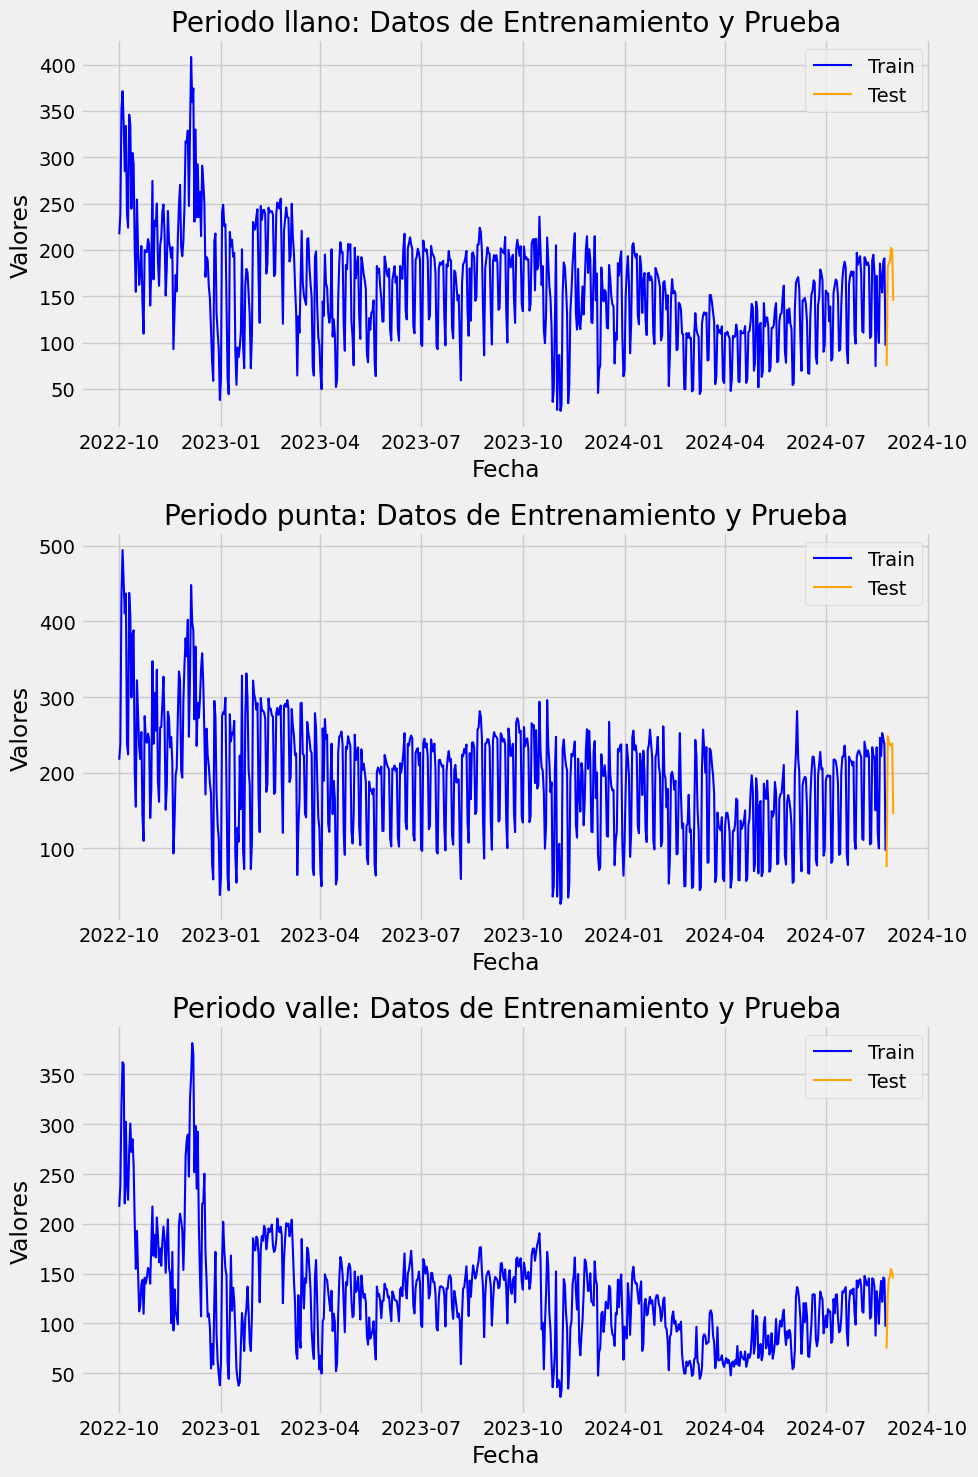

In [7]:
import matplotlib.pyplot as plt

# Supongamos que ya tienes tus DataFrames: datos_train y datos_test

# Crear una figura con 3 subgráficas (1 columna y 3 filas)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 filas, 1 columna

# Trazar datos para 'y_1'
axs[0].plot(datos_train.index, datos_train['y_1'], label='Train', color='blue')
axs[0].plot(datos_test.index, datos_test['y_1'], label='Test', color='orange')
axs[0].set_title('Periodo llano: Datos de Entrenamiento y Prueba')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Valores')
axs[0].legend()

# Trazar datos para 'y_2'
axs[1].plot(datos_train.index, datos_train['y_2'], label='Train', color='blue')
axs[1].plot(datos_test.index, datos_test['y_2'], label='Test', color='orange')
axs[1].set_title('Periodo punta: Datos de Entrenamiento y Prueba')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valores')
axs[1].legend()

# Trazar datos para 'y_3'
axs[2].plot(datos_train.index, datos_train['y_3'], label='Train', color='blue')
axs[2].plot(datos_test.index, datos_test['y_3'], label='Test', color='orange')
axs[2].set_title('Periodo valle: Datos de Entrenamiento y Prueba')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Valores')
axs[2].legend()

# Ajustar el diseño
plt.tight_layout()

# Mostrar los gráficos
plt.show()


**INCLUSIÓN DE LAGS (Obtenidos en Correlation.ipynb**

In [7]:
#'Llano': 'y_1', 'Punta': 'y_2', 'Valle': 'y_3'
lags_y_1 = pd.read_csv('data/lags_significativos_tramo_llano.csv')['Lag'].values
lags_y_2 = pd.read_csv('data/lags_significativos_tramo_punta.csv')['Lag'].values
lags_y_3 = pd.read_csv('data/lags_significativos_tramo_valle.csv')['Lag'].values
lags = {'y_1': lags_y_1, 'y_2': lags_y_2, 'y_3': lags_y_3}

**Vizualización de Resultados**

In [8]:
pd.set_option('display.max_colwidth', None)  # Establecer 'None' para no limitar el ancho de las columnas

def replace_etiqueta_por_valor_real(row):
    etiquetas = {
        'y_1': 'Llano',
        'y_2': 'Punta',
        'y_3': 'Valle'
    }
    return etiquetas.get(row, row)  # Devuelve el valor correspondiente o el original

# ***Experimentos***

### **EXPERIMENTO BASE**

#### Codigo Lags

In [11]:
import pandas as pd

def train_forecaster_with_model(models, steps):
    # Crear un DataFrame vacío para almacenar los resultados
    resultados_list = []

    # Iterar sobre cada variable objetivo
    for target_variable in ['y_1', 'y_2', 'y_3']:
        print(f'Entrenando modelo para la variable {target_variable}...')

        for model in models:
            # Crear y ajustar el modelo
            if model in [SVR, LinearRegression]:
                forecaster = ForecasterAutoreg(
                    regressor=model(),
                    lags=lags[target_variable]
                )
            else:
                forecaster = ForecasterAutoreg(
                    regressor=model(random_state=123),
                    lags=lags[target_variable]
                )

            # Ajustar el modelo usando la variable objetivo actual
            forecaster.fit(y=datos_train[target_variable])
            predicciones = forecaster.predict(steps=steps)

            # Graficar resultados
            '''fig, ax = plt.subplots(figsize=(9, 4))
            #datos_train[target_variable].plot(ax=ax, label='train', color='blue')
            datos_test[target_variable].plot(ax=ax, label='test', color='orange')
            predicciones.plot(ax=ax, label='predicciones', color='green')
            ax.set_title(f'Predicciones usando {model.__name__} para {target_variable}')
            ax.legend();'''

            # Calcular métricas de bondad
            mse = mean_squared_error(datos_test[target_variable], predicciones)
            #rmse = np.sqrt(mse)
            #mae = mean_absolute_error(datos_test[target_variable], predicciones)
            #mape = np.mean(np.abs((datos_test[target_variable] - predicciones) / datos_test[target_variable])) * 100
            #r2 = r2_score(datos_test[target_variable], predicciones)

            if model == RandomForestRegressor:
                hiperparametros = {
                    'n_estimators': forecaster.regressor.get_params()['n_estimators'],
                    'max_depth': forecaster.regressor.get_params()['max_depth'],
                    'min_samples_split': forecaster.regressor.get_params()['min_samples_split'],
                    'min_samples_leaf': forecaster.regressor.get_params()['min_samples_leaf']
                }
            elif model == XGBRegressor:
                hiperparametros = {
                    'n_estimators': forecaster.regressor.get_params()['n_estimators'],
                    'learning_rate': forecaster.regressor.get_params()['learning_rate'],
                    'max_depth': forecaster.regressor.get_params()['max_depth'],
                    'subsample': forecaster.regressor.get_params()['subsample']
                }
            elif model == DecisionTreeRegressor:
                hiperparametros = {
                    'max_depth': forecaster.regressor.get_params()['max_depth'],
                    'min_samples_split': forecaster.regressor.get_params()['min_samples_split'],
                    'min_samples_leaf': forecaster.regressor.get_params()['min_samples_leaf']
                }
            elif model == SVR:
                hiperparametros = {
                    'C': forecaster.regressor.get_params()['C'],
                    'epsilon': forecaster.regressor.get_params()['epsilon']
                }
            elif model == LinearRegression:
                hiperparametros = {
                }


            # Almacenar resultados en el DataFrame
            resultados_list.append({
                'Modelo': model.__name__,
                'Hiperparámetros': hiperparametros,  # Guardar los hiperparámetros en esta columna
                'Variable': target_variable,
                'MSE': mse,
                #'RMSE': rmse,
                #'MAE': mae,
                #'MAPE': mape,
                #'R2': r2
            })

    resultados = pd.DataFrame(resultados_list)
    return resultados

models_to_test = [
    RandomForestRegressor,
    XGBRegressor,
    DecisionTreeRegressor,
    SVR,
    LinearRegression
]

steps = 7
resultados = train_forecaster_with_model(models_to_test, steps)

resultados.sort_values(by = 'MSE')

Entrenando modelo para la variable y_1...
Entrenando modelo para la variable y_2...
Entrenando modelo para la variable y_3...


Modelo                                    Hiperparámetros  \
12  DecisionTreeRegressor  {'max_depth': None, 'min_samples_split': 2, 'm...   
10  RandomForestRegressor  {'n_estimators': 100, 'max_depth': None, 'min_...   
11           XGBRegressor  {'n_estimators': None, 'learning_rate': None, ...   
6            XGBRegressor  {'n_estimators': None, 'learning_rate': None, ...   
13                    SVR                         {'C': 1.0, 'epsilon': 0.1}   
5   RandomForestRegressor  {'n_estimators': 100, 'max_depth': None, 'min_...   
14       LinearRegression                                                 {}   
2   DecisionTreeRegressor  {'max_depth': None, 'min_samples_split': 2, 'm...   
1            XGBRegressor  {'n_estimators': None, 'learning_rate': None, ...   
9        LinearRegression                                                 {}   
0   RandomForestRegressor  {'n_estimators': 100, 'max_depth': None, 'min_...   
3                     SVR                         {'C': 1.0, 'epsilon': 0.1}   
4        LinearRegression                                                 {}   
7   DecisionTreeRegressor  {'max_depth': None, 'min_samples_split': 2, 'm...   
8                     SVR                         {'C': 1.0, 'epsilon': 0.1}   

   Variable          MSE  
12      y_3   109.330587  
10      y_3   370.645995  
11      y_3   378.763590  
6       y_2   471.075841  
13      y_3   551.754140  
5       y_2   636.988392  
14      y_3   709.245405  
2       y_1   795.590036  
1       y_1   796.333747  
9       y_2   862.092208  
0       y_1   907.247155  
3       y_1   986.369617  
4       y_1  1153.363953  
7       y_2  1402.423127  
8       y_2  1434.873301

In [12]:
resultados['Variable'] = resultados['Variable'].apply(replace_etiqueta_por_valor_real)
resultados

Modelo  \
0   RandomForestRegressor   
1            XGBRegressor   
2   DecisionTreeRegressor   
3                     SVR   
4        LinearRegression   
5   RandomForestRegressor   
6            XGBRegressor   
7   DecisionTreeRegressor   
8                     SVR   
9        LinearRegression   
10  RandomForestRegressor   
11           XGBRegressor   
12  DecisionTreeRegressor   
13                    SVR   
14       LinearRegression   

                                                                            Hiperparámetros  \
0   {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
1       {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
2                        {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
3                                                                {'C': 1.0, 'epsilon': 0.1}   
4                                                                                        {}   
5   {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
6       {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
7                        {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
8                                                                {'C': 1.0, 'epsilon': 0.1}   
9                                                                                        {}   
10  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
11      {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
12                       {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
13                                                               {'C': 1.0, 'epsilon': 0.1}   
14                                                                                       {}   

   Variable          MSE  
0     Llano   907.247155  
1     Llano   796.333747  
2     Llano   795.590036  
3     Llano   986.369617  
4     Llano  1153.363953  
5     Punta   636.988392  
6     Punta   471.075841  
7     Punta  1402.423127  
8     Punta  1434.873301  
9     Punta   862.092208  
10    Valle   370.645995  
11    Valle   378.763590  
12    Valle   109.330587  
13    Valle   551.754140  
14    Valle   709.245405

#### Resultados Lags

In [13]:
def replace_etiqueta_por_valor_real(row):
    etiquetas = {
        'y_1': 'Llano',
        'y_2': 'Punta',
        'y_3': 'Valle'
    }
    return etiquetas.get(row, row)  # Devuelve el valor correspondiente o el original

# Obtener los mejores modelos
mejores_modelos = resultados.loc[
    resultados.groupby('Variable')['MSE'].idxmin()
]

# Aplicar la función a la columna 'Variable'
mejores_modelos['Variable'] = mejores_modelos['Variable'].apply(replace_etiqueta_por_valor_real)

Modelo  \
2   DecisionTreeRegressor   
6            XGBRegressor   
12  DecisionTreeRegressor   

                                                                        Hiperparámetros  \
2                    {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
6   {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
12                   {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   

   Variable         MSE  
2     Llano  795.590036  
6     Punta  471.075841  
12    Valle  109.330587

In [ ]:
mejores_modelos


#### Codigo ARIMA

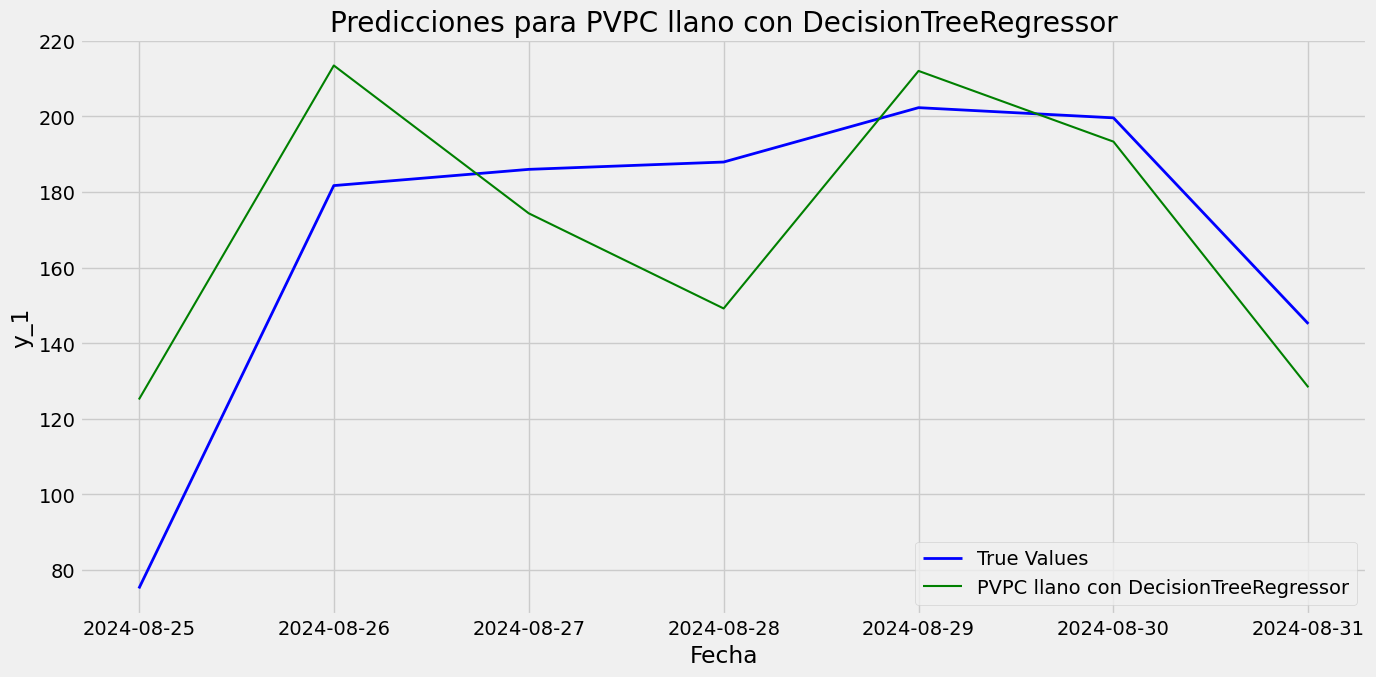

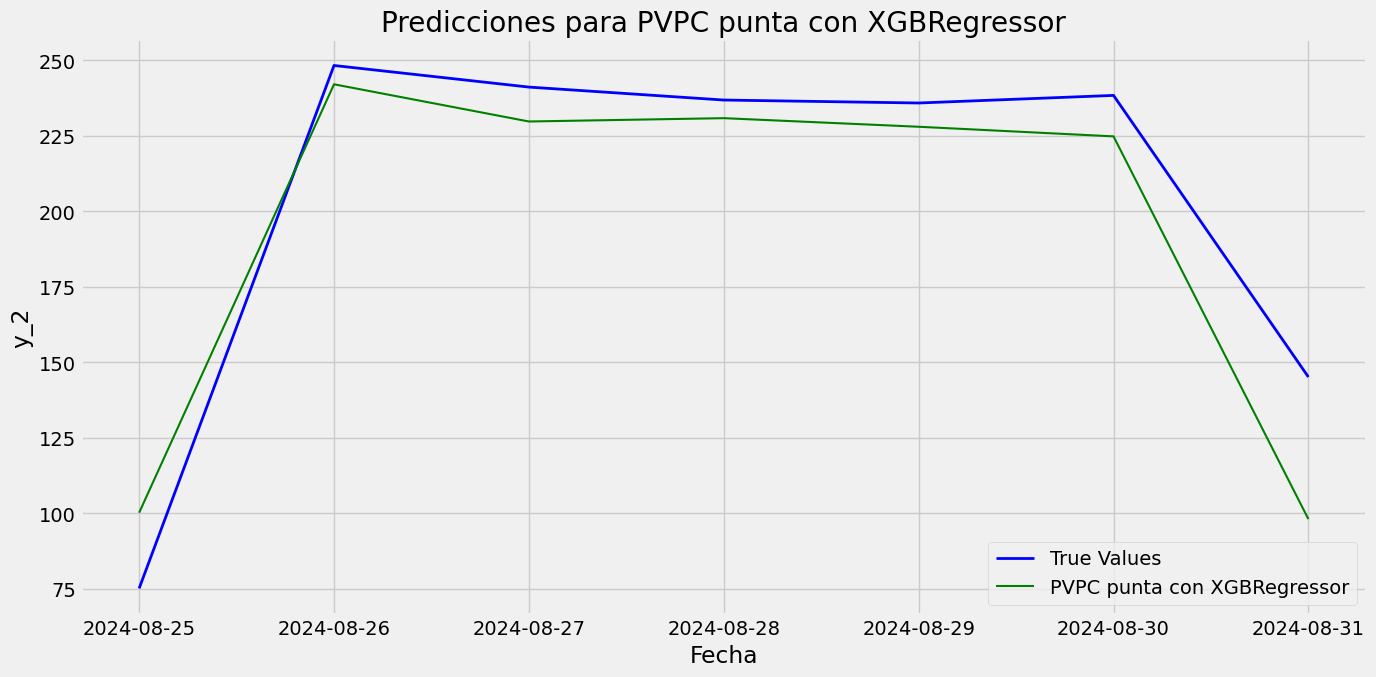

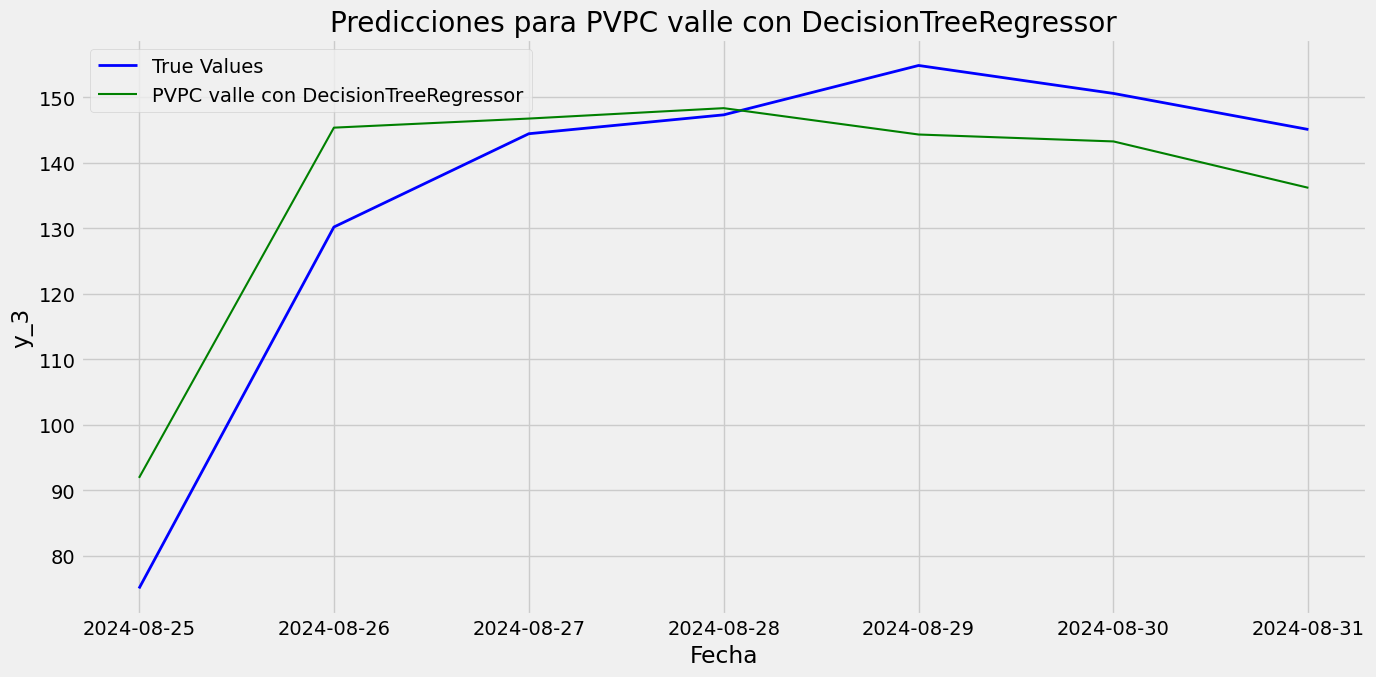

In [61]:
import seaborn as sns
lags = {'y_1': lags_y_1, 'y_2': lags_y_2, 'y_3': lags_y_3}
def fit_and_predict(model, datos_train, target_variable, steps=7):
    forecaster = ForecasterAutoreg(
        regressor=model(random_state=123),
        lags=lags[target_variable]
    )
    # Ajustar el modelo usando la variable objetivo actual
    forecaster.fit(y=datos_train[target_variable])
    # Realizar predicciones
    predicciones = forecaster.predict(steps=steps)
    return predicciones

# Función para plotear las predicciones y los valores reales
def plot_predictions(y_true, pred1, title):
    plt.figure(figsize=(14, 7))

    # Plot de predicciones
    sns.lineplot(data=y_true, label='True Values', color='blue', linewidth=2)
    sns.lineplot(data=pred1, label=f'{title}', color='green')

    plt.title(f'Predicciones para {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Definir los modelos para cada variable
model_y1 = DecisionTreeRegressor
model_y2 = XGBRegressor
model_y3 = DecisionTreeRegressor

# Realizar predicciones para cada serie temporal
pred_y1 = fit_and_predict(model_y1, datos_train, 'y_1')
pred_y2 = fit_and_predict(model_y2, datos_train, 'y_2')
pred_y3 = fit_and_predict(model_y3, datos_train, 'y_3')

# Graficar las predicciones
plot_predictions(datos_test['y_1'], pred_y1, title="PVPC llano con DecisionTreeRegressor")
plot_predictions(datos_test['y_2'], pred_y2, title="PVPC punta con XGBRegressor")
plot_predictions(datos_test['y_3'], pred_y3, title="PVPC valle con DecisionTreeRegressor")

In [36]:
###ARIMA
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Lista para almacenar resultados
resultados_list = []

# Definir rangos para p, d y q
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

# Diccionario para almacenar el mejor modelo por variable
mejores_modelos = {}

# Iterar sobre cada variable objetivo
for target_variable in ['y_1', 'y_2', 'y_3']:
    print(f'Buscando el mejor modelo ARIMA para {target_variable}...')
    mejor_mse = float('inf')  # Inicializar con infinito
    mejor_hyperparams = None  # Inicializar hiperparámetros

    # Probar diferentes combinaciones de p, d y q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # Definir el modelo ARIMA
                    modelo_arima = ARIMA(datos_train[target_variable], order=(p, d, q))
                    modelo_arima_fit = modelo_arima.fit()

                    # Realizar predicciones
                    steps = 7
                    predicciones = modelo_arima_fit.forecast(steps=steps)

                    # Calcular el MSE
                    mse = mean_squared_error(datos_test[target_variable][:steps], predicciones)

                    # Almacenar resultados
                    resultados_list.append({
                        'Modelo': 'ARIMA',
                        'Hiperparámetros': (p, d, q),
                        'Variable': target_variable,
                        'MSE': mse
                    })

                    # Verificar si este es el mejor modelo
                    if mse < mejor_mse:
                        mejor_mse = mse
                        mejor_hyperparams = (p, d, q)

                except Exception as e:
                    print(f'Error con p={p}, d={d}, q={q} para {target_variable}: {e}')

    # Almacenar el mejor modelo por variable
    mejores_modelos[target_variable] = {
        'Hiperparámetros': mejor_hyperparams,
        'MSE': mejor_mse
    }

# Convertir resultados_list a DataFrame
resultados_arima = pd.DataFrame(resultados_list)

# Mostrar el mejor modelo por variable
print("\nMejores modelos encontrados por variable:")
for variable, modelo in mejores_modelos.items():
    print(f"{variable}: Hiperparámetros = {modelo['Hiperparámetros']}, MSE = {modelo['MSE']}")

Buscando el mejor modelo ARIMA para y_1...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: Us

Buscando el mejor modelo ARIMA para y_2...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWar

Buscando el mejor modelo ARIMA para y_3...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta


Mejores modelos encontrados por variable:
y_1: Hiperparámetros = (3, 0, 3), MSE = 1090.017412120288
y_2: Hiperparámetros = (2, 1, 2), MSE = 1406.2141947148234
y_3: Hiperparámetros = (0, 0, 2), MSE = 472.1433763983379


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Resultados ARIMA

In [38]:
mejores_modelos

{'y_1': {'Hiperparámetros': (3, 0, 3), 'MSE': 1090.017412120288},
 'y_2': {'Hiperparámetros': (2, 1, 2), 'MSE': 1406.2141947148234},
 'y_3': {'Hiperparámetros': (0, 0, 2), 'MSE': 472.1433763983379}}

In [40]:
mejores_modelos_arima = pd.DataFrame.from_dict(
    {variable: {'Modelo': 'ARIMA', **info} for variable, info in mejores_modelos.items()},
    orient='index'
).reset_index().rename(columns={'index': 'Variable'})
mejores_modelos_arima

Variable Modelo Hiperparámetros          MSE
0      y_1  ARIMA       (3, 0, 3)  1090.017412
1      y_2  ARIMA       (2, 1, 2)  1406.214195
2      y_3  ARIMA       (0, 0, 2)   472.143376

In [41]:
mejores_modelos_arima['Variable'] = mejores_modelos_arima['Variable'].apply(replace_etiqueta_por_valor_real)
mejores_modelos_arima

Variable Modelo Hiperparámetros          MSE
0    Llano  ARIMA       (3, 0, 3)  1090.017412
1    Punta  ARIMA       (2, 1, 2)  1406.214195
2    Valle  ARIMA       (0, 0, 2)   472.143376

### **EXPERIMENTO BACKTESTING**

#### Codigo

In [41]:
steps = 7
n_folds = 20
N_BACKTESTING = steps * n_folds

def train_forecaster_with_model(models, steps):
    # Crear un DataFrame vacío para almacenar los resultados
    resultados_list = []

    # Iterar sobre cada variable objetivo
    for target_variable in ['y_1', 'y_2', 'y_3']:
        print(f'Entrenando modelo para la variable {target_variable}...')

        for model in models:
            # Crear y ajustar el modelo
            if model in [SVR, LinearRegression]:
                forecaster = ForecasterAutoreg(
                    regressor=model(),  # No random_state para SVR
                    lags=lags[target_variable]
                )
            else:
                forecaster = ForecasterAutoreg(
                    regressor=model(random_state=123),
                    lags=lags[target_variable]
                )

            if model == RandomForestRegressor:
                hiperparametros = {
                    'n_estimators': forecaster.regressor.get_params()['n_estimators'],
                    'max_depth': forecaster.regressor.get_params()['max_depth'],
                    'min_samples_split': forecaster.regressor.get_params()['min_samples_split'],
                    'min_samples_leaf': forecaster.regressor.get_params()['min_samples_leaf']
                }
            elif model == XGBRegressor:
                hiperparametros = {
                    'n_estimators': forecaster.regressor.get_params()['n_estimators'],
                    'learning_rate': forecaster.regressor.get_params()['learning_rate'],
                    'max_depth': forecaster.regressor.get_params()['max_depth'],
                    'subsample': forecaster.regressor.get_params()['subsample']
                }
            elif model == DecisionTreeRegressor:
                hiperparametros = {
                    'max_depth': forecaster.regressor.get_params()['max_depth'],
                    'min_samples_split': forecaster.regressor.get_params()['min_samples_split'],
                    'min_samples_leaf': forecaster.regressor.get_params()['min_samples_leaf']
                }
            elif model == SVR:
                hiperparametros = {
                    'C': forecaster.regressor.get_params()['C'],
                    'epsilon': forecaster.regressor.get_params()['epsilon']
                }
            elif model == LinearRegression:
                hiperparametros = {
                }

            # Realizar backtesting
            n_backtesting = N_BACKTESTING
            metrica, predicciones_backtest = backtesting_forecaster(
                forecaster         = forecaster,
                y                  = datos_train[target_variable],
                initial_train_size = len(datos_train) - n_backtesting,
                fixed_train_size   = False,
                steps              = steps,
                refit              = True,
                metric             = 'mean_squared_error',
                verbose            = True
            )

            # Calcular métricas de bondad
            mse = metrica

            # Almacenar resultados en el DataFrame
            resultados_list.append({
                'Modelo': model.__name__,
                'Variable': target_variable,
                'Hiperparámetros': hiperparametros,
                'MSE': mse
            })

    resultados = pd.DataFrame(resultados_list)
    return resultados

models_to_test = [
    RandomForestRegressor,
    XGBRegressor,
    DecisionTreeRegressor,
    SVR,
    LinearRegression
]

resultados = train_forecaster_with_model(models_to_test, steps)
resultados

Entrenando modelo para la variable y_1...
Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Entrenando modelo para la variable y_2...
Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Entrenando modelo para la variable y_3...
Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

  0%|          | 0/20 [00:00<?, ?it/s]

Modelo Variable  \
0   RandomForestRegressor      y_1   
1            XGBRegressor      y_1   
2   DecisionTreeRegressor      y_1   
3                     SVR      y_1   
4        LinearRegression      y_1   
5   RandomForestRegressor      y_2   
6            XGBRegressor      y_2   
7   DecisionTreeRegressor      y_2   
8                     SVR      y_2   
9        LinearRegression      y_2   
10  RandomForestRegressor      y_3   
11           XGBRegressor      y_3   
12  DecisionTreeRegressor      y_3   
13                    SVR      y_3   
14       LinearRegression      y_3   

                                                                            Hiperparámetros  \
0   {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
1       {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
2                        {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
3                                                                {'C': 1.0, 'epsilon': 0.1}   
4                                                                                        {}   
5   {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
6       {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
7                        {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
8                                                                {'C': 1.0, 'epsilon': 0.1}   
9                                                                                        {}   
10  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
11      {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
12                       {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
13                                                               {'C': 1.0, 'epsilon': 0.1}   
14                                                                                       {}   

                                            MSE  
0      mean_squared_error
0          578.196301  
1      mean_squared_error
0          674.553625  
2      mean_squared_error
0         1398.715762  
3      mean_squared_error
0         1054.341803  
4      mean_squared_error
0           508.12836  
5      mean_squared_error
0          806.760178  
6      mean_squared_error
0         1066.700369  
7      mean_squared_error
0         1853.475872  
8      mean_squared_error
0         2191.758919  
9      mean_squared_error
0          900.617916  
10     mean_squared_error
0          317.738705  
11     mean_squared_error
0          383.931044  
12     mean_squared_error
0          693.473826  
13     mean_squared_error
0          500.973777  
14     mean_squared_error
0          357.520785

#### Resultados

In [42]:
resultados['MSE'] = resultados['MSE'].astype(str)
resultados['MSE'] = resultados['MSE'].str.replace('mean_squared_error\n0', '', regex=False)
resultados['MSE'] = resultados['MSE'].astype(float)
resultados['Variable'] = resultados['Variable'].apply(replace_etiqueta_por_valor_real)
resultados.sort_values(by = ['Variable', 'MSE'])

Modelo Variable  \
4        LinearRegression    Llano   
0   RandomForestRegressor    Llano   
1            XGBRegressor    Llano   
3                     SVR    Llano   
2   DecisionTreeRegressor    Llano   
5   RandomForestRegressor    Punta   
9        LinearRegression    Punta   
6            XGBRegressor    Punta   
7   DecisionTreeRegressor    Punta   
8                     SVR    Punta   
10  RandomForestRegressor    Valle   
14       LinearRegression    Valle   
11           XGBRegressor    Valle   
13                    SVR    Valle   
12  DecisionTreeRegressor    Valle   

                                                                            Hiperparámetros  \
4                                                                                        {}   
0   {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
1       {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
3                                                                {'C': 1.0, 'epsilon': 0.1}   
2                        {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
5   {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
9                                                                                        {}   
6       {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
7                        {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
8                                                                {'C': 1.0, 'epsilon': 0.1}   
10  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
14                                                                                       {}   
11      {'n_estimators': None, 'learning_rate': None, 'max_depth': None, 'subsample': None}   
13                                                               {'C': 1.0, 'epsilon': 0.1}   
12                       {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   

            MSE  
4    508.128360  
0    578.196301  
1    674.553625  
3   1054.341803  
2   1398.715762  
5    806.760178  
9    900.617916  
6   1066.700369  
7   1853.475872  
8   2191.758919  
10   317.738705  
14   357.520785  
11   383.931044  
13   500.973777  
12   693.473826

In [43]:
mejores_resultados_bt = resultados.loc[
    resultados.groupby('Variable')['MSE'].idxmin()
]
mejores_resultados_bt

Modelo Variable  \
4        LinearRegression    Llano   
5   RandomForestRegressor    Punta   
10  RandomForestRegressor    Valle   

                                                                            Hiperparámetros  \
4                                                                                        {}   
5   {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
10  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   

           MSE  
4   508.128360  
5   806.760178  
10  317.738705

#### Graficas

MSE para LinearRegression: 1153.3639525993142


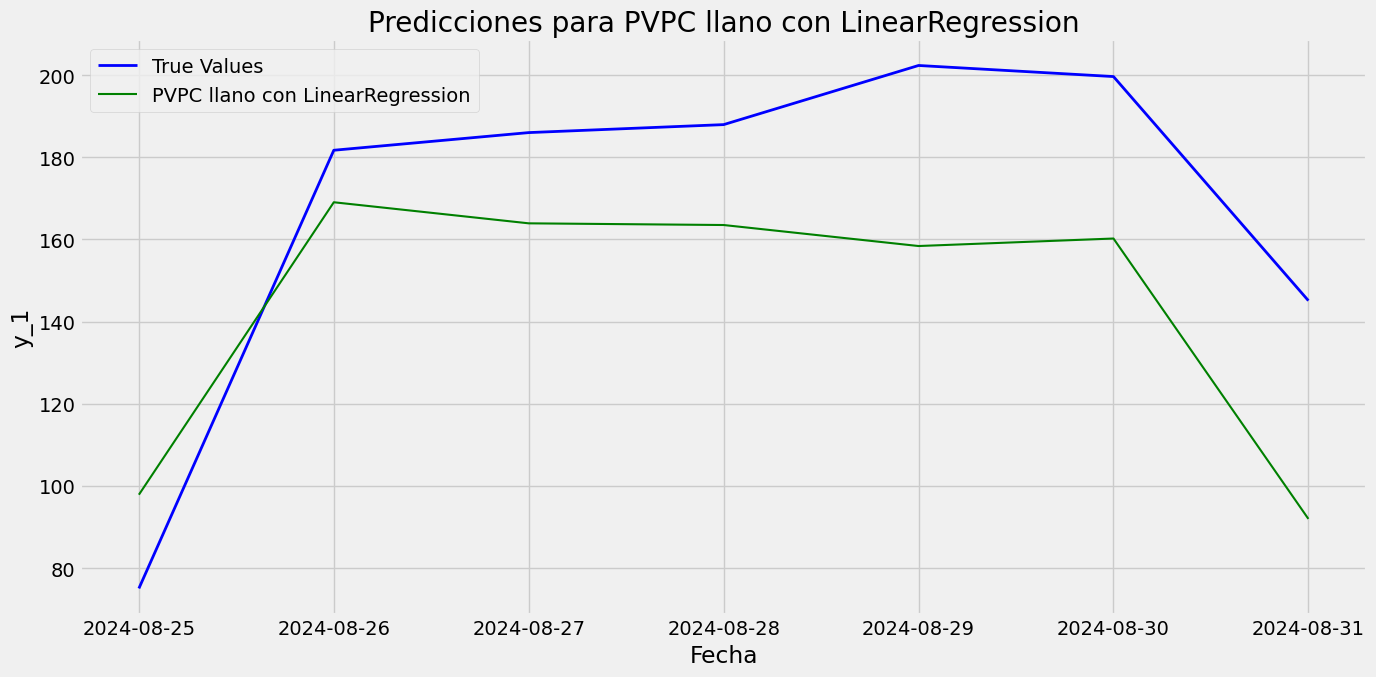

MSE para RandomForestRegressor: 644.4559857622774


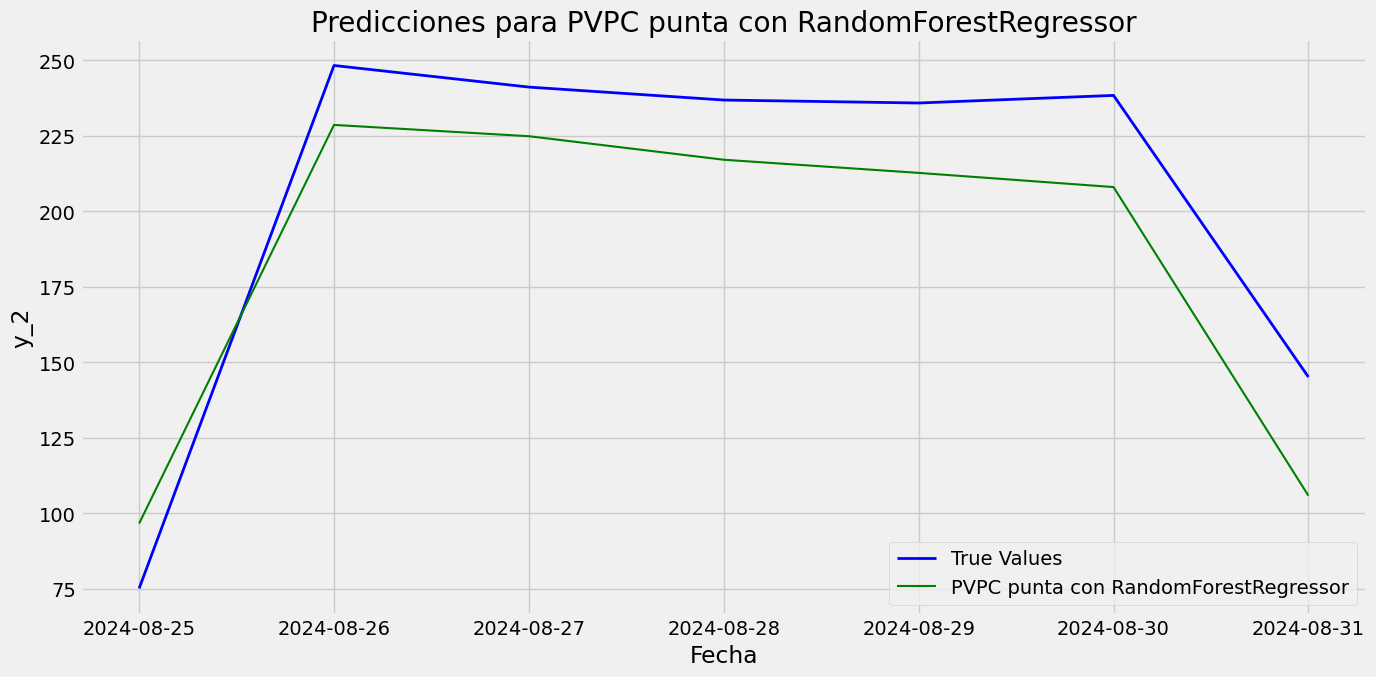

MSE para RandomForestRegressor: 458.60455744310127


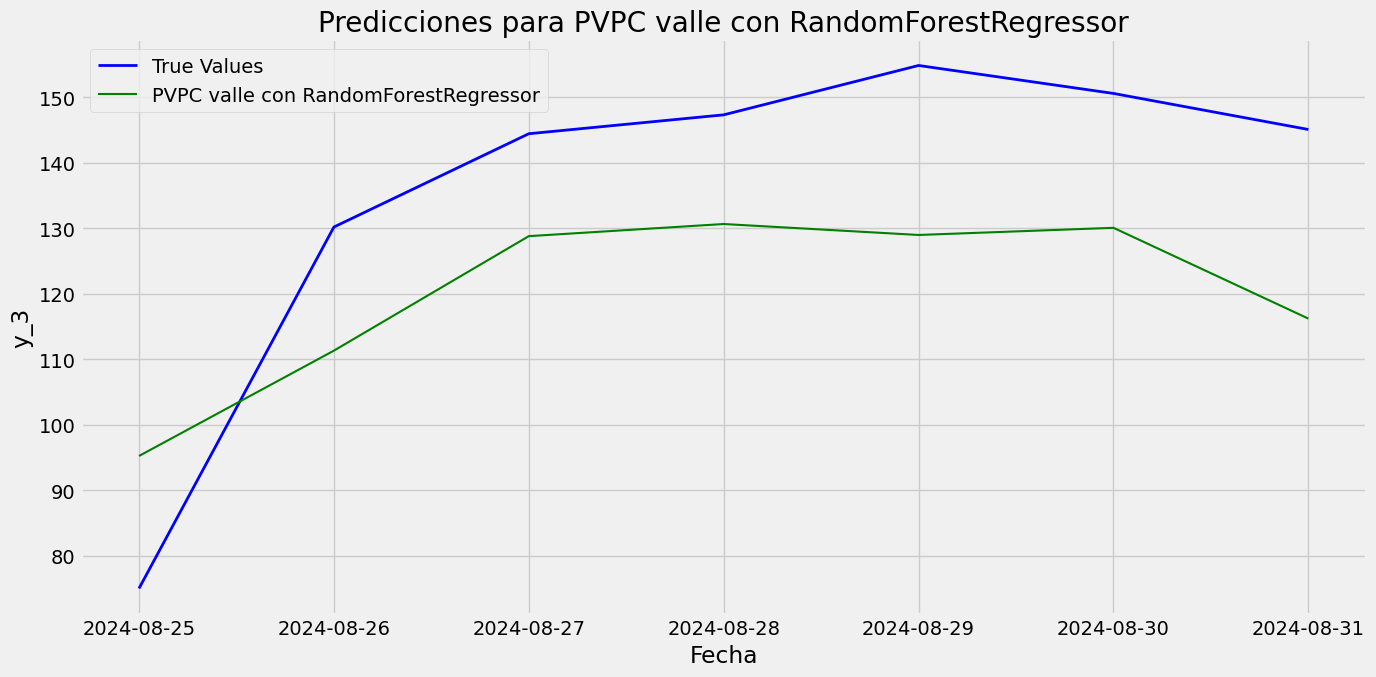

Modelo Variable  \
0       LinearRegression    Llano   
1  RandomForestRegressor    Punta   
2  RandomForestRegressor    Valle   

                                                                           Hiperparámetros  \
0                                                                                       {}   
1  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   
2  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}   

           MSE  
0  1153.363953  
1   644.455986  
2   458.604557

In [47]:
import seaborn as sns
lags = {'y_1': lags_y_1, 'y_2': lags_y_2, 'y_3': lags_y_3}
def fit_and_predict(model, params, datos_train, target_variable, steps=7):
    forecaster = ForecasterAutoreg(
        regressor=model(**params),
        lags=lags[target_variable]
    )
    # Ajustar el modelo usando la variable objetivo actual
    forecaster.fit(y=datos_train[target_variable])
    # Realizar predicciones
    predicciones = forecaster.predict(steps=steps)
    return predicciones

# Función para plotear las predicciones y los valores reales
def plot_predictions(y_true, pred1, title):
    plt.figure(figsize=(14, 7))

    # Plot de predicciones
    sns.lineplot(data=y_true, label='True Values', color='blue', linewidth=2)
    sns.lineplot(data=pred1, label=f'{title}', color='green')

    plt.title(f'Predicciones para {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Definir los modelos para cada variable
model_y1 = mejores_resultados_bt['Modelo'].reset_index(drop=True)[0]
model_y2 = mejores_resultados_bt['Modelo'].reset_index(drop=True)[1]
model_y3 = mejores_resultados_bt['Modelo'].reset_index(drop=True)[2]

modelo_dict = {
    'RandomForestRegressor': RandomForestRegressor,
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'SVR': SVR,
    'LinearRegression': LinearRegression
}

# Obtener las clases de los modelos
clase_model_y1 = modelo_dict[model_y1]
clase_model_y2 = modelo_dict[model_y2]
clase_model_y3 = modelo_dict[model_y3]

mejores_parametros_1 = mejores_resultados_bt['Hiperparámetros'].reset_index(drop=True)[0]
mejores_parametros_2 = mejores_resultados_bt['Hiperparámetros'].reset_index(drop=True)[1]
mejores_parametros_3 = mejores_resultados_bt['Hiperparámetros'].reset_index(drop=True)[2]

# Realizar predicciones para cada serie temporal
pred_y1 = fit_and_predict(clase_model_y1, mejores_parametros_1, datos_train, 'y_1')
pred_y2 = fit_and_predict(clase_model_y2, mejores_parametros_2, datos_train, 'y_2')
pred_y3 = fit_and_predict(clase_model_y3, mejores_parametros_3, datos_train, 'y_3')

# Calcular y imprimir el error cuadrático medio (MSE) para cada modelo
mse_y1 = mean_squared_error(datos_test['y_1'], pred_y1)
mse_y2 = mean_squared_error(datos_test['y_2'], pred_y2)
mse_y3 = mean_squared_error(datos_test['y_3'], pred_y3)

# Graficar las predicciones
print(f'MSE para {model_y1}: {mse_y1}')
plot_predictions(datos_test['y_1'], pred_y1, title=f"PVPC llano con {model_y1}")

print(f'MSE para {model_y2}: {mse_y2}')
plot_predictions(datos_test['y_2'], pred_y2, title=f"PVPC punta con {model_y2}")

print(f'MSE para {model_y3}: {mse_y3}')
plot_predictions(datos_test['y_3'], pred_y3, title=f"PVPC valle con {model_y3}")

resultados_bt_sobre_test = mejores_resultados_bt.copy().reset_index(drop = True)
resultados_bt_sobre_test.loc[0,'MSE'] = mse_y1
resultados_bt_sobre_test.loc[1,'MSE'] = mse_y2
resultados_bt_sobre_test.loc[2,'MSE'] = mse_y3
resultados_bt_sobre_test

### **EXPERIMENTO GRID SEARCH + BACKTESTING**

#### Codigo

In [50]:
steps = 7
n_folds = 20
n_backtesting = steps * n_folds

def train_forecaster_with_model_optimization(models, steps):
    resultados_list = []

    # Definición de la cuadrícula de hiperparámetros para cada modelo
    hyperparams = {
        RandomForestRegressor: {
            'param_grid': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 10]
            },
        },
        XGBRegressor: {
            'param_grid': {
                'n_estimators': [None, 100, 200],
                'max_depth': [None, 3, 5, 10],
                'learning_rate': [None, 0.01, 0.1]
            },
        },
        DecisionTreeRegressor: {
            'param_grid': {
                'min_samples_leaf': [1, 2, 3],
                'max_depth': [None, 3, 5, 10],
                'min_samples_split': [2, 5]
                },
        },
        SVR: {
            'param_grid': {
                'C': [0.1, 1, 10],
                'epsilon': [0.1, 0.2]
            },
        },

        LinearRegression: {
            'param_grid': {},
        }
    }

    # Iterar sobre cada variable objetivo
    for target_variable in ['y_1', 'y_2', 'y_3']:
        print(f'Entrenando modelo para la variable {target_variable}...')

        for model in models:
         forecaster = ForecasterAutoreg(
                  regressor=model(),
                  lags=lags[target_variable]
            )

         param_grid = hyperparams[model]['param_grid']

         # Realizar Grid Search con Backtesting
         resultados_grid = grid_search_forecaster(
              forecaster         = forecaster,
              y                  = datos_train[target_variable],
              param_grid         = param_grid,
              initial_train_size = len(datos_train) - n_backtesting,
              fixed_train_size   = False,
              steps              = steps,
              refit              = True,
              metric             = 'mean_squared_error',
              return_best        = True,
              verbose            = True
          )

         best_params = resultados_grid.loc[resultados_grid['mean_squared_error'].idxmin()]['params']
         best_MSE = resultados_grid['mean_squared_error'].min()

         # Guardar resultados
         resultados_list.append({
              'Modelo': model.__name__,
              'Variable': target_variable,
              'Mejores Parámetros': best_params,
              'Mejor MSE': best_MSE,
          })

    # Convertir la lista de resultados a un DataFrame
    resultados_finales = pd.DataFrame(resultados_list)

    return resultados_finales

models_to_test = [
    RandomForestRegressor,
    XGBRegressor,
    DecisionTreeRegressor,
    SVR,
    LinearRegression
]  # Lista de modelos a probar

resultados_gs = train_forecaster_with_model_optimization(models_to_test, steps)

# Mostrar los resultados
resultados_gs

Entrenando modelo para la variable y_1...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/24 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/24 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/24 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Modelo Variable  \
0   RandomForestRegressor      y_1   
1            XGBRegressor      y_1   
2   DecisionTreeRegressor      y_1   
3                     SVR      y_1   
4        LinearRegression      y_1   
5   RandomForestRegressor      y_2   
6            XGBRegressor      y_2   
7   DecisionTreeRegressor      y_2   
8                     SVR      y_2   
9        LinearRegression      y_2   
10  RandomForestRegressor      y_3   
11           XGBRegressor      y_3   
12  DecisionTreeRegressor      y_3   
13                    SVR      y_3   
14       LinearRegression      y_3   

                                                 Mejores Parámetros  \
0                            {'max_depth': 10, 'n_estimators': 200}   
1      {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}   
2   {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}   
3                                         {'C': 10, 'epsilon': 0.1}   
4                                                                {}   
5                            {'max_depth': 10, 'n_estimators': 100}   
6      {'learning_rate': None, 'max_depth': 5, 'n_estimators': 200}   
7   {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}   
8                                         {'C': 10, 'epsilon': 0.2}   
9                                                                {}   
10                           {'max_depth': 10, 'n_estimators': 200}   
11      {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}   
12  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}   
13                                        {'C': 10, 'epsilon': 0.2}   
14                                                               {}   

      Mejor MSE  
0    556.965900  
1    554.038790  
2   1003.704647  
3    593.343170  
4    508.128360  
5    834.679666  
6    912.592305  
7   1483.903167  
8    861.285800  
9    900.617916  
10   321.819691  
11   311.952752  
12   473.098808  
13   336.911315  
14   357.520785

#### Resultados

In [51]:
resultados_gs['Variable'] = resultados_gs['Variable'].apply(replace_etiqueta_por_valor_real)
resultados_gs.sort_values(by = ['Variable', 'Mejor MSE'])

Modelo Variable  \
4        LinearRegression    Llano   
1            XGBRegressor    Llano   
0   RandomForestRegressor    Llano   
3                     SVR    Llano   
2   DecisionTreeRegressor    Llano   
5   RandomForestRegressor    Punta   
8                     SVR    Punta   
9        LinearRegression    Punta   
6            XGBRegressor    Punta   
7   DecisionTreeRegressor    Punta   
11           XGBRegressor    Valle   
10  RandomForestRegressor    Valle   
13                    SVR    Valle   
14       LinearRegression    Valle   
12  DecisionTreeRegressor    Valle   

                                                 Mejores Parámetros  \
4                                                                {}   
1      {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}   
0                            {'max_depth': 10, 'n_estimators': 200}   
3                                         {'C': 10, 'epsilon': 0.1}   
2   {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}   
5                            {'max_depth': 10, 'n_estimators': 100}   
8                                         {'C': 10, 'epsilon': 0.2}   
9                                                                {}   
6      {'learning_rate': None, 'max_depth': 5, 'n_estimators': 200}   
7   {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}   
11      {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}   
10                           {'max_depth': 10, 'n_estimators': 200}   
13                                        {'C': 10, 'epsilon': 0.2}   
14                                                               {}   
12  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}   

      Mejor MSE  
4    508.128360  
1    554.038790  
0    556.965900  
3    593.343170  
2   1003.704647  
5    834.679666  
8    861.285800  
9    900.617916  
6    912.592305  
7   1483.903167  
11   311.952752  
10   321.819691  
13   336.911315  
14   357.520785  
12   473.098808

In [52]:
best_resultados_gs = resultados_gs.loc[
    resultados_gs.groupby('Variable')['Mejor MSE'].idxmin()
]
best_resultados_gs

Modelo Variable  \
4        LinearRegression    Llano   
5   RandomForestRegressor    Punta   
11           XGBRegressor    Valle   

                                             Mejores Parámetros   Mejor MSE  
4                                                            {}  508.128360  
5                        {'max_depth': 10, 'n_estimators': 100}  834.679666  
11  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}  311.952752

MSE para LinearRegression: 1153.3639525993142


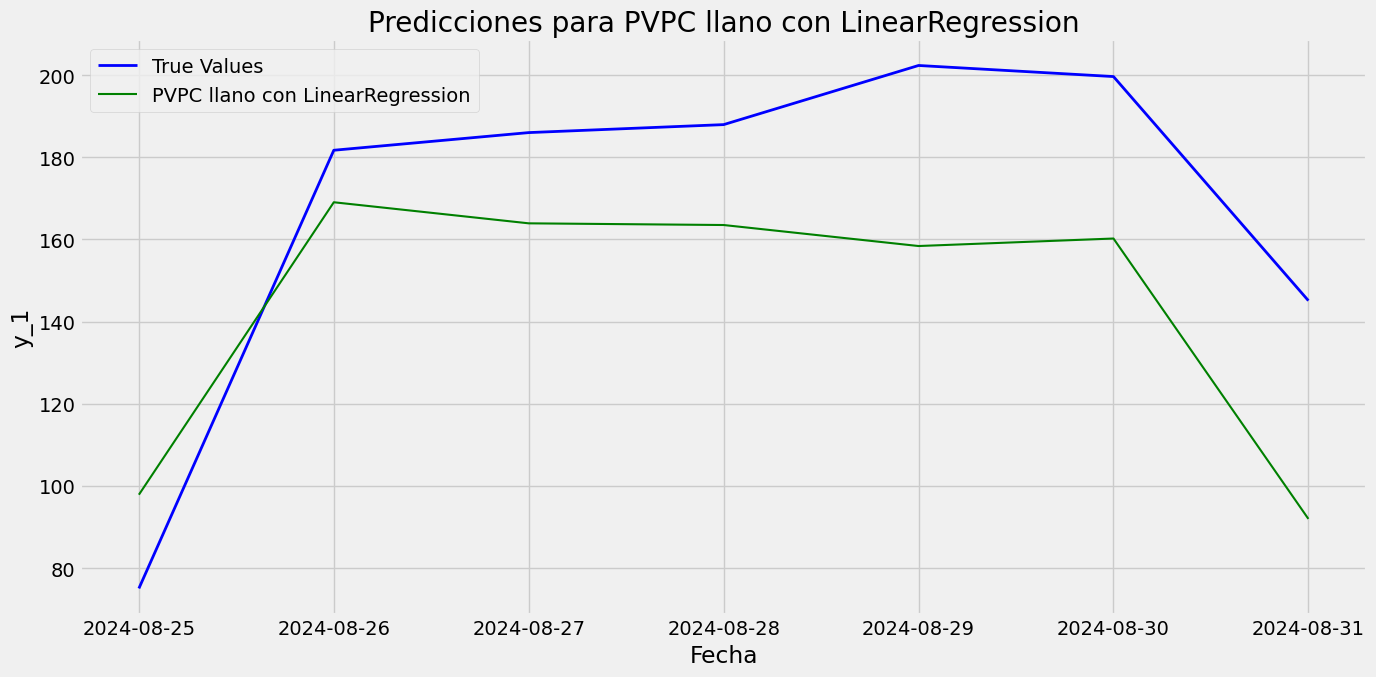

MSE para RandomForestRegressor: 658.7057211413955


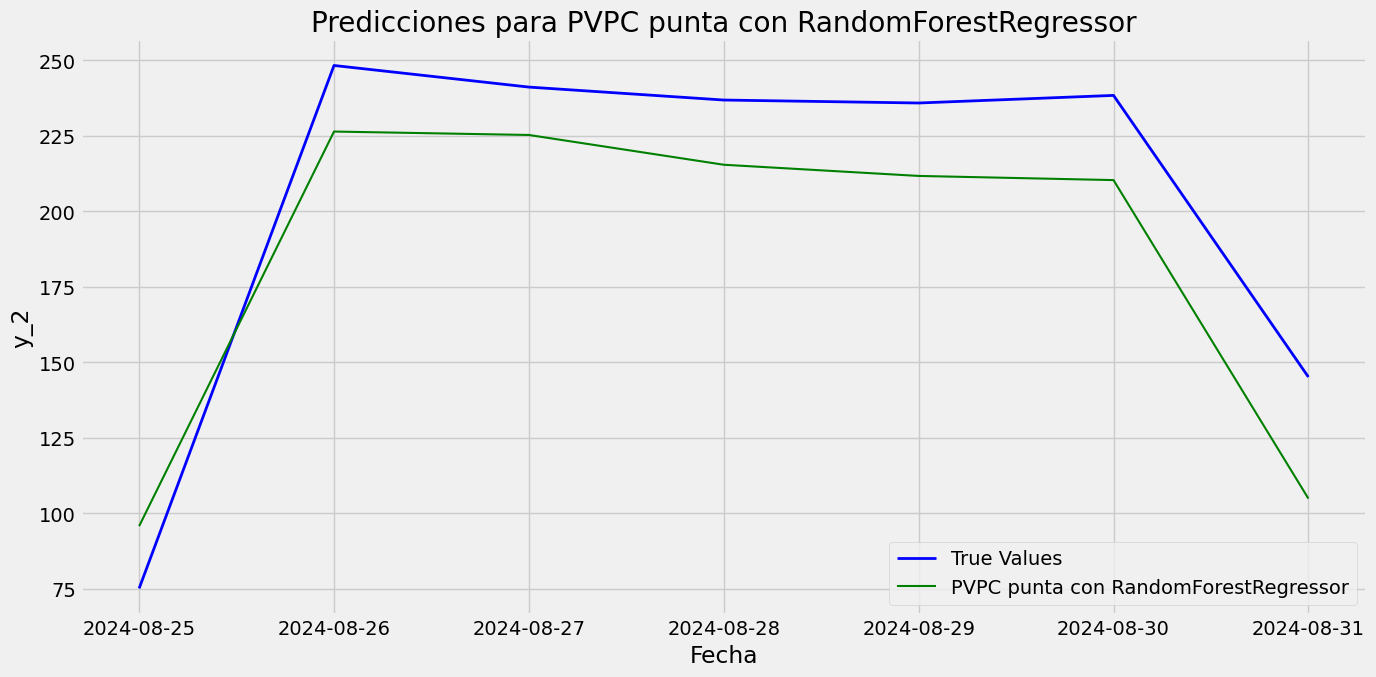

MSE para XGBRegressor: 319.80861739897875


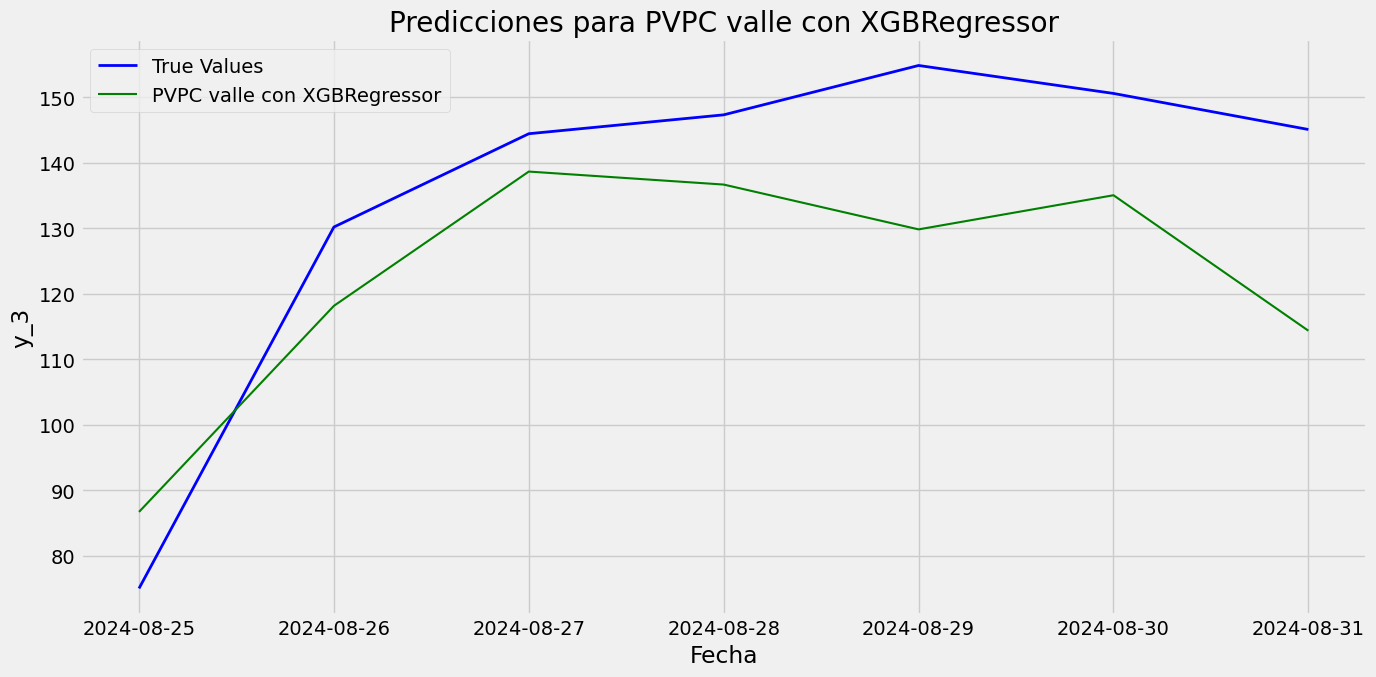

Modelo Variable  \
0       LinearRegression    Llano   
1  RandomForestRegressor    Punta   
2           XGBRegressor    Valle   

                                            Mejores Parámetros   Mejor MSE  \
0                                                           {}  508.128360   
1                       {'max_depth': 10, 'n_estimators': 100}  834.679666   
2  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}  311.952752   

           MSE  
0  1153.363953  
1   658.705721  
2   319.808617

In [57]:
import seaborn as sns
lags = {'y_1': lags_y_1, 'y_2': lags_y_2, 'y_3': lags_y_3}
def fit_and_predict(model, params, datos_train, target_variable, steps=7):
    forecaster = ForecasterAutoreg(
        regressor=model(**params),
        lags=lags[target_variable]
    )
    # Ajustar el modelo usando la variable objetivo actual
    forecaster.fit(y=datos_train[target_variable])
    # Realizar predicciones
    predicciones = forecaster.predict(steps=steps)
    return predicciones

# Función para plotear las predicciones y los valores reales
def plot_predictions(y_true, pred1, title):
    plt.figure(figsize=(14, 7))

    # Plot de predicciones
    sns.lineplot(data=y_true, label='True Values', color='blue', linewidth=2)
    sns.lineplot(data=pred1, label=f'{title}', color='green')

    plt.title(f'Predicciones para {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Definir los modelos para cada variable
model_y1 = best_resultados_gs['Modelo'].reset_index(drop=True)[0]
model_y2 = best_resultados_gs['Modelo'].reset_index(drop=True)[1]
model_y3 = best_resultados_gs['Modelo'].reset_index(drop=True)[2]

modelo_dict = {
    'RandomForestRegressor': RandomForestRegressor,
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'SVR': SVR,
    'LinearRegression': LinearRegression
}

# Obtener las clases de los modelos
clase_model_y1 = modelo_dict[model_y1]
clase_model_y2 = modelo_dict[model_y2]
clase_model_y3 = modelo_dict[model_y3]

mejores_parametros_1 = best_resultados_gs['Mejores Parámetros'].reset_index(drop=True)[0]
mejores_parametros_2 = best_resultados_gs['Mejores Parámetros'].reset_index(drop=True)[1]
mejores_parametros_3 = best_resultados_gs['Mejores Parámetros'].reset_index(drop=True)[2]

# Realizar predicciones para cada serie temporal
pred_y1 = fit_and_predict(clase_model_y1, mejores_parametros_1, datos_train, 'y_1')
pred_y2 = fit_and_predict(clase_model_y2, mejores_parametros_2, datos_train, 'y_2')
pred_y3 = fit_and_predict(clase_model_y3, mejores_parametros_3, datos_train, 'y_3')

# Calcular y imprimir el error cuadrático medio (MSE) para cada modelo
mse_y1 = mean_squared_error(datos_test['y_1'], pred_y1)
mse_y2 = mean_squared_error(datos_test['y_2'], pred_y2)
mse_y3 = mean_squared_error(datos_test['y_3'], pred_y3)

# Graficar las predicciones
print(f'MSE para {model_y1}: {mse_y1}')
plot_predictions(datos_test['y_1'], pred_y1, title=f"PVPC llano con {model_y1}")

print(f'MSE para {model_y2}: {mse_y2}')
plot_predictions(datos_test['y_2'], pred_y2, title=f"PVPC punta con {model_y2}")

print(f'MSE para {model_y3}: {mse_y3}')
plot_predictions(datos_test['y_3'], pred_y3, title=f"PVPC valle con {model_y3}")

resultados_bt_gs_sobre_test = best_resultados_gs.copy().reset_index(drop = True)
resultados_bt_gs_sobre_test.loc[0,'MSE'] = mse_y1
resultados_bt_gs_sobre_test.loc[1,'MSE'] = mse_y2
resultados_bt_gs_sobre_test.loc[2,'MSE'] = mse_y3
resultados_bt_gs_sobre_test

### **EXPERIMENTO CON VARIABLES EXÓGENAS**

#### Codigo

In [11]:
steps = 7
n_folds = 20
n_backtesting = steps * n_folds

def train_forecaster_with_model_optimization(models, steps, exog_dict=None):
    resultados_list = []

    # Definición de la cuadrícula de hiperparámetros para cada modelo
    hyperparams = {
        RandomForestRegressor: {
            'param_grid': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 10]
            },
        },
        XGBRegressor: {
            'param_grid': {
                'n_estimators': [None, 100, 200],
                'max_depth': [None, 3, 5, 10],
                'learning_rate': [None, 0.01, 0.1]
            },
        },
        DecisionTreeRegressor: {
            'param_grid': {
                'min_samples_leaf': [1, 2, 3],
                'max_depth': [None, 3, 5, 10],
                'min_samples_split': [2, 5]
                },
        },
        SVR: {
            'param_grid': {
                'C': [0.1, 1, 10],
                'epsilon': [0.1, 0.2]
            },
        },

        LinearRegression: {
            'param_grid': {},
        }
    }

    # Iterar sobre cada variable objetivo
    for target_variable in ['y_1', 'y_2', 'y_3']:
        print(f'Entrenando modelo para la variable {target_variable}...')

        for model in models:
            if model in [SVR, LinearRegression]:
                forecaster = ForecasterAutoreg(
                    regressor=model(),  # No random_state para SVR
                    lags=lags[target_variable]
                )
            else:
                forecaster = ForecasterAutoreg(
                    regressor=model(),
                    lags=lags[target_variable]
                )

            # Obtener la exógena correspondiente
            exog_train = exog_dict[target_variable][:-steps] if exog_dict else None

            # Realizar  Grid Search con Backtesting
            param_grid = hyperparams[model]['param_grid']
            resultados_grid = grid_search_forecaster(
                forecaster          = forecaster,
                y                   = datos_train[target_variable],
                exog                = exog_train,
                param_grid          = param_grid,
                steps               = steps,
                refit               = True,
                metric              = 'mean_squared_error',
                initial_train_size  = len(datos_train) - n_backtesting,#int(len(datos_train) * 0.5),
                fixed_train_size    = False,
                return_best         = True,
                verbose             = True
            )

            best_params = resultados_grid.loc[resultados_grid['mean_squared_error'].idxmin()]['params']
            best_MSE = resultados_grid['mean_squared_error'].min()

            # Guardar resultados
            resultados_list.append({
                'Modelo': model.__name__,
                'Variable': target_variable,
                'Mejores Parámetros': best_params,
                'Mejor MSE': best_MSE
            })

    # Convertir la lista de resultados a un DataFrame
    resultados_finales = pd.DataFrame(resultados_list)

    return resultados_finales

models_to_test = [
    RandomForestRegressor,
    XGBRegressor,
    DecisionTreeRegressor,
    SVR,
    LinearRegression
]

# Usar la columna 'Demanda_Llano' como variable exógena
datos['exog_1_1'] = datos['Demanda_Llano']
datos['exog_1_2'] = datos['Demanda_Punta']
datos['exog_1_3'] = datos['Demanda_Valle']

# Usar la columna 'Pai Gasolina 95 E5' como variable exógena
datos['exog_2'] = datos['Pai Gasolina 95 E5']

# Diccionario de exógenas
exog_dict_1 = {
    'y_1': datos['exog_1_1'],
    'y_2': datos['exog_1_2'],
    'y_3': datos['exog_1_3']
}

exog_dict_2 = {
    'y_1': datos['exog_2'],
    'y_2': datos['exog_2'],
    'y_3': datos['exog_2']
}

exog_dict_combined = {
    'y_1': datos[['Demanda_Llano', 'Pai Gasolina 95 E5']],
    'y_2': datos[['Demanda_Punta', 'Pai Gasolina 95 E5']],
    'y_3': datos[['Demanda_Valle', 'Pai Gasolina 95 E5']]
}

# Resultados para cada exógena
resultados_exog_1 = train_forecaster_with_model_optimization(models_to_test, steps, exog_dict_1)
resultados_exog_2 = train_forecaster_with_model_optimization(models_to_test, steps, exog_dict_2)
resultados_combined = train_forecaster_with_model_optimization(models_to_test, steps, exog_dict_combined)
resultados_no_exog = train_forecaster_with_model_optimization(models_to_test, steps)

# Añadir la columna 'Exogena'
resultados_exog_1['Exogena'] = 'Demanda'
resultados_exog_2['Exogena'] = 'Precio Gasolina'
resultados_combined['Exogena'] = 'Demanda + Precio Gasolina'
resultados_no_exog['Exogena'] = '-'

# Combinar resultados
resultados = pd.concat([resultados_exog_1, resultados_exog_2, resultados_combined, resultados_no_exog])

# Ordenar resultados
resultados = resultados.sort_values(by=['Variable', 'Mejor MSE', 'Exogena'], ascending=[True, False, True])

resultados

Entrenando modelo para la variable y_1...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:34<00:00, 34.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 344.74936077760174

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [03:28<00:00, 208.20s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': None}
  Backtesting metric: 372.6973387458997

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'C': 10, 'epsilon': 0.1}
  Backtesting metric: 874.8244882851332

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {}
  Backtesting metric: 346.00608200974114

Entrenando modelo para la variable y_2...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:35<00:00, 35.32s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 683.4870833865853

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [03:02<00:00, 182.27s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None}
  Backtesting metric: 605.1201784754468

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

params grid:  58%|█████▊    | 14/24 [00:01<00:01,  9.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Backtesting metric: 1088.3042480842855

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'C': 10, 'epsilon': 0.2}
  Backtesting metric: 1472.27469433334

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {}
  Backtesting metric: 721.0837184125442

Entrenando modelo para la variable y_3...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:48<00:00, 48.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 308.93398134739516

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [04:06<00:00, 246.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': None}
  Backtesting metric: 331.42129212867775

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Backtesting metric: 473.0988076603909

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'C': 10, 'epsilon': 0.1}
  Backtesting metric: 928.7775797281064

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {}
  Backtesting metric: 306.32755294651844

Entrenando modelo para la variable y_1...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:38<00:00, 38.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 556.9344494882595

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [03:29<00:00, 209.76s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 200}
  Backtesting metric: 551.8553662355891

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

params grid:  75%|███████▌  | 18/24 [00:02<00:00,  8.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Backtesting metric: 1003.7046469106825

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'C': 10, 'epsilon': 0.1}
  Backtesting metric: 599.3090173796791

Number of models compared: 1.


lags grid: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:35<00:00, 35.15s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 813.3585951911627

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [03:02<00:00, 182.12s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': None}
  Backtesting metric: 929.5380414265114

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'C': 10, 'epsilon': 0.2}
  Backtesting metric: 863.0632197927486

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {}
  Backtesting metric: 947.3678313195855

Entrenando modelo para la variable y_3...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:49<00:00, 49.05s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 321.9201138069751

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [04:03<00:00, 243.55s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None}
  Backtesting metric: 334.7819536490767

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
  Backtesting metric: 457.8242219215165

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'C': 10, 'epsilon': 0.2}
  Backtesting metric: 333.6888826016752

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {}
  Backtesting metric: 401.77251283595643

Entrenando modelo para la variable y_1...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:37<00:00, 37.76s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 328.9789634856692

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [03:24<00:00, 204.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 384.50028534361746

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'C': 10, 'epsilon': 0.1}
  Backtesting metric: 875.0378360213076

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {}
  Backtesting metric: 360.0334313165493

Entrenando modelo para la variable y_2...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:35<00:00, 35.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 688.462401933018

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [03:02<00:00, 182.38s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 682.448770070409

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation


params grid:  46%|████▌     | 11/24 [00:01<00:01,  8.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
  Backtesting metric: 1088.3042480842853

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'C': 10, 'epsilon': 0.2}
  Backtesting metric: 1472.3899173006246

Number of models compared: 1.


lags grid: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:49<00:00, 49.01s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 303.49382722889555

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [04:08<00:00, 248.74s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': None}
  Backtesting metric: 301.4830128681716

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation


params grid:  33%|███▎      | 8/24 [00:01<00:02,  5.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

params grid:  42%|████▏     | 10/24 [00:01<00:02,  6.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'C': 10, 'epsilon': 0.1}
  Backtesting metric: 928.8291018599123

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {}
  Backtesting metric: 337.11179308597383

Entrenando modelo para la variable y_1...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:36<00:00, 36.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 571.5687127429982

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [03:21<00:00, 201.44s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 554.0387897837101

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {'C': 10, 'epsilon': 0.1}
  Backtesting metric: 593.3431697364376

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 20 21 22 27 28 29 34 35 36 41
 42 48 49 50 55 56 57 62 63 64 69 70 71 76 77 78 84 91 98] 
  Parameters: {}
  Backtesting metric: 508.12835977550577

Entrenando modelo para la variable y_2...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:34<00:00, 34.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 800.819420325402

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [02:58<00:00, 178.42s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'learning_rate': None, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 912.5923050727844

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Backtesting metric: 1483.9031672865165

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {'C': 10, 'epsilon': 0.2}
  Backtesting metric: 861.2858001194929

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  6  7  8 13 14 15 20 21 22 27 28 29 34 35 36 41 42 43 48 49 50 55 56
 57 62 63 64 69 70 71 76 77 84 85 90 91 92 98] 
  Parameters: {}
  Backtesting metric: 900.6179155891476

Entrenando modelo para la variable y_3...
Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:47<00:00, 47.93s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 302.20030785684065

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [04:05<00:00, 245.02s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 311.95275242382536

Number of models compared: 24.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]
/home/guillermo/uc3m/2.1/flujos/practica/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Backtesting metric: 473.0988076603911

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {'C': 10, 'epsilon': 0.2}
  Backtesting metric: 336.91131450872774

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 554
Number of observations used for backtesting: 140
    Number of folds: 20
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-10-01 00:00:00 -- 2024-04-06 00:00:00  (n=554)
    Validation: 2024-04-07 00:00:00 -- 2024-04-13 00:00:00  (n=7)
Fold: 1
    Training:   2022-10-01 00:00:00 -- 2024-04-13 00:00:00  (n=561)
    Validation: 2024-04-14 00:00:00 -- 2024-04-20 00:00:00  (n=7)
Fold: 2
    Training:   2022-10-01 00:00:00 -- 2024-04-20 00:00:00  (n=568)
    Validation: 2024-04-21 00:00:00 -- 2024-04-27 00:00:00  (n=7)
Fold: 3
    Training:   2022-10-01 00:00:00 -- 2024-04-27 00:00:00  (n=575)
    Validation: 2024-04-28 00:00:00 -- 2024-05-04 00:00:00  (n=7)
Fold: 4
    Training:   2022-10-01 00:00:00 -- 2024-05-04 00:00:00  (n=582)
    Validation

lags grid: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70] 
  Parameters: {}
  Backtesting metric: 357.5207848838589



Modelo Variable  \
2   DecisionTreeRegressor      y_1   
2   DecisionTreeRegressor      y_1   
3                     SVR      y_1   
3                     SVR      y_1   
2   DecisionTreeRegressor      y_1   
3                     SVR      y_1   
3                     SVR      y_1   
0   RandomForestRegressor      y_1   
0   RandomForestRegressor      y_1   
1            XGBRegressor      y_1   
1            XGBRegressor      y_1   
2   DecisionTreeRegressor      y_1   
4        LinearRegression      y_1   
4        LinearRegression      y_1   
1            XGBRegressor      y_1   
1            XGBRegressor      y_1   
4        LinearRegression      y_1   
4        LinearRegression      y_1   
0   RandomForestRegressor      y_1   
0   RandomForestRegressor      y_1   
7   DecisionTreeRegressor      y_2   
7   DecisionTreeRegressor      y_2   
8                     SVR      y_2   
8                     SVR      y_2   
7   DecisionTreeRegressor      y_2   
7   DecisionTreeRegressor      y_2   
9        LinearRegression      y_2   
6            XGBRegressor      y_2   
6            XGBRegressor      y_2   
9        LinearRegression      y_2   
8                     SVR      y_2   
8                     SVR      y_2   
5   RandomForestRegressor      y_2   
5   RandomForestRegressor      y_2   
9        LinearRegression      y_2   
9        LinearRegression      y_2   
5   RandomForestRegressor      y_2   
5   RandomForestRegressor      y_2   
6            XGBRegressor      y_2   
6            XGBRegressor      y_2   
13                    SVR      y_3   
13                    SVR      y_3   
12  DecisionTreeRegressor      y_3   
12  DecisionTreeRegressor      y_3   
12  DecisionTreeRegressor      y_3   
12  DecisionTreeRegressor      y_3   
14       LinearRegression      y_3   
14       LinearRegression      y_3   
14       LinearRegression      y_3   
13                    SVR      y_3   
11           XGBRegressor      y_3   
13                    SVR      y_3   
11           XGBRegressor      y_3   
10  RandomForestRegressor      y_3   
11           XGBRegressor      y_3   
10  RandomForestRegressor      y_3   
14       LinearRegression      y_3   
10  RandomForestRegressor      y_3   
10  RandomForestRegressor      y_3   
11           XGBRegressor      y_3   

                                                    Mejores Parámetros  \
2      {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}   
2      {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}   
3                                            {'C': 10, 'epsilon': 0.1}   
3                                            {'C': 10, 'epsilon': 0.1}   
2   {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}   
3                                            {'C': 10, 'epsilon': 0.1}   
3                                            {'C': 10, 'epsilon': 0.1}   
0                               {'max_depth': 10, 'n_estimators': 200}   
0                               {'max_depth': 10, 'n_estimators': 100}   
1         {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}   
1      {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 200}   
2     {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}   
4                                                                   {}   
4                                                                   {}   
1          {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}   
1         {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': None}   
4                                                                   {}   
4                                                                   {}   
0                               {'max_depth': 10, 'n_estimators': 200}   
0                               {'max_depth': 10, 'n_estimators': 200}   
7      {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}   
7      {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}  

#### Resultados

In [12]:
resultados['Variable'] = resultados['Variable'].apply(replace_etiqueta_por_valor_real)
resultados.sort_values(by = ['Variable', 'Mejor MSE'])

Modelo Variable  \
0   RandomForestRegressor    Llano   
0   RandomForestRegressor    Llano   
4        LinearRegression    Llano   
4        LinearRegression    Llano   
1            XGBRegressor    Llano   
1            XGBRegressor    Llano   
4        LinearRegression    Llano   
4        LinearRegression    Llano   
2   DecisionTreeRegressor    Llano   
1            XGBRegressor    Llano   
1            XGBRegressor    Llano   
0   RandomForestRegressor    Llano   
0   RandomForestRegressor    Llano   
3                     SVR    Llano   
3                     SVR    Llano   
2   DecisionTreeRegressor    Llano   
3                     SVR    Llano   
3                     SVR    Llano   
2   DecisionTreeRegressor    Llano   
2   DecisionTreeRegressor    Llano   
6            XGBRegressor    Punta   
6            XGBRegressor    Punta   
5   RandomForestRegressor    Punta   
5   RandomForestRegressor    Punta   
9        LinearRegression    Punta   
9        LinearRegression    Punta   
5   RandomForestRegressor    Punta   
5   RandomForestRegressor    Punta   
8                     SVR    Punta   
8                     SVR    Punta   
9        LinearRegression    Punta   
6            XGBRegressor    Punta   
6            XGBRegressor    Punta   
9        LinearRegression    Punta   
7   DecisionTreeRegressor    Punta   
7   DecisionTreeRegressor    Punta   
8                     SVR    Punta   
8                     SVR    Punta   
7   DecisionTreeRegressor    Punta   
7   DecisionTreeRegressor    Punta   
11           XGBRegressor    Valle   
10  RandomForestRegressor    Valle   
10  RandomForestRegressor    Valle   
14       LinearRegression    Valle   
10  RandomForestRegressor    Valle   
11           XGBRegressor    Valle   
10  RandomForestRegressor    Valle   
11           XGBRegressor    Valle   
13                    SVR    Valle   
11           XGBRegressor    Valle   
13                    SVR    Valle   
14       LinearRegression    Valle   
14       LinearRegression    Valle   
14       LinearRegression    Valle   
12  DecisionTreeRegressor    Valle   
12  DecisionTreeRegressor    Valle   
12  DecisionTreeRegressor    Valle   
12  DecisionTreeRegressor    Valle   
13                    SVR    Valle   
13                    SVR    Valle   

                                                    Mejores Parámetros  \
0                               {'max_depth': 10, 'n_estimators': 200}   
0                               {'max_depth': 10, 'n_estimators': 200}   
4                                                                   {}   
4                                                                   {}   
1         {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': None}   
1          {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}   
4                                                                   {}   
4                                                                   {}   
2     {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}   
1      {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 200}   
1         {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}   
0                               {'max_depth': 10, 'n_estimators': 100}   
0                               {'max_depth': 10, 'n_estimators': 200}   
3                                            {'C': 10, 'epsilon': 0.1}   
3                                            {'C': 10, 'epsilon': 0.1}   
2   {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}   
3                                            {'C': 10, 'epsilon': 0.1}   
3                                            {'C': 10, 'epsilon': 0.1}   
2      {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}   
2      {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}   
6         {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None}   
6          {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}  

In [13]:
best_resultados_exog = resultados.loc[
    resultados.groupby('Variable')['Mejor MSE'].idxmin()
]
best_resultados_exog

Modelo Variable  \
0   RandomForestRegressor    Llano   
0   RandomForestRegressor    Llano   
0   RandomForestRegressor    Llano   
0   RandomForestRegressor    Llano   
6            XGBRegressor    Punta   
6            XGBRegressor    Punta   
6            XGBRegressor    Punta   
6            XGBRegressor    Punta   
11           XGBRegressor    Valle   
11           XGBRegressor    Valle   
11           XGBRegressor    Valle   
11           XGBRegressor    Valle   

                                                 Mejores Parámetros  \
0                            {'max_depth': 10, 'n_estimators': 200}   
0                            {'max_depth': 10, 'n_estimators': 100}   
0                            {'max_depth': 10, 'n_estimators': 200}   
0                            {'max_depth': 10, 'n_estimators': 200}   
6   {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': None}   
6      {'learning_rate': None, 'max_depth': 5, 'n_estimators': 200}   
6       {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}   
6      {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None}   
11     {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None}   
11     {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': None}   
11      {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}   
11  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': None}   

     Mejor MSE                    Exogena  
0   571.568713                          -  
0   556.934449            Precio Gasolina  
0   344.749361                    Demanda  
0   328.978963  Demanda + Precio Gasolina  
6   929.538041            Precio Gasolina  
6   912.592305                          -  
6   682.448770  Demanda + Precio Gasolina  
6   605.120178                    Demanda  
11  334.781954            Precio Gasolina  
11  331.421292                    Demanda  
11  311.952752                          -  
11  301.483013  Demanda + Precio Gasolina

In [10]:
parametros_otros = {
    '1_1': {'max_depth': 10, 'n_estimators': 200},
    '1_2': {'max_depth': 10, 'n_estimators': 100},
    '1_3': {'max_depth': 10, 'n_estimators': 200},
    '2_1': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None},
    '2_2': {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': None},
    '2_3': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
    '3_1': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': None},
    '3_2': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None}	,
    '3_3': {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': None}
}

In [18]:
# Seleccionar las columnas 'Variable', 'Modelo' y 'Exogena'
selected_columns = best_resultados_exog[['Variable', 'Modelo', 'Exogena', 'Mejor MSE']]

# Imprimir las columnas seleccionadas
print(selected_columns)

   Variable                 Modelo                    Exogena   Mejor MSE
0     Llano  RandomForestRegressor                          -  571.568713
0     Llano  RandomForestRegressor            Precio Gasolina  556.934449
0     Llano  RandomForestRegressor                    Demanda  344.749361
0     Llano  RandomForestRegressor  Demanda + Precio Gasolina  328.978963
6     Punta           XGBRegressor            Precio Gasolina  929.538041
6     Punta           XGBRegressor                          -  912.592305
6     Punta           XGBRegressor  Demanda + Precio Gasolina  682.448770
6     Punta           XGBRegressor                    Demanda  605.120178
11    Valle           XGBRegressor            Precio Gasolina  334.781954
11    Valle           XGBRegressor                    Demanda  331.421292
11    Valle           XGBRegressor                          -  311.952752
11    Valle           XGBRegressor  Demanda + Precio Gasolina  301.483013


#### Graficas

MSE para RandomForestRegressor con Demanda de Electricidad: 655.7267542060737


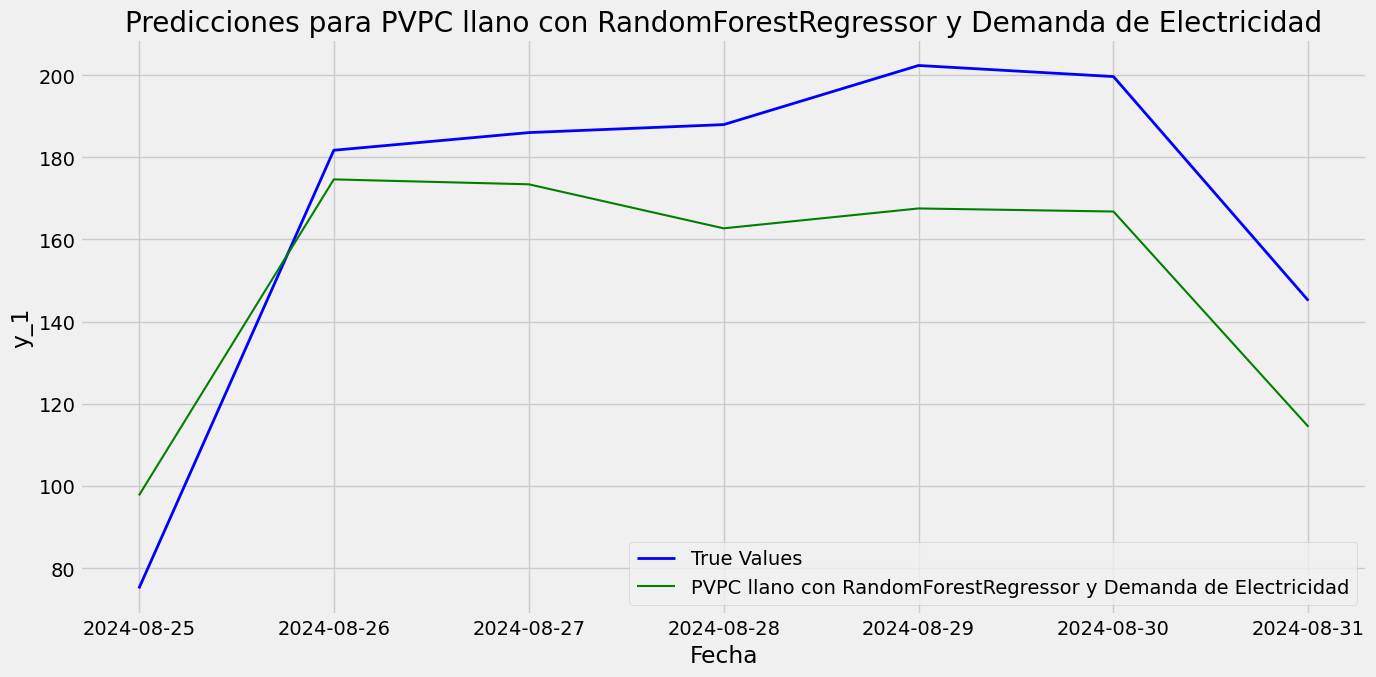

MSE para RandomForestRegressor con Precio de Gasolina: 778.0294201990845


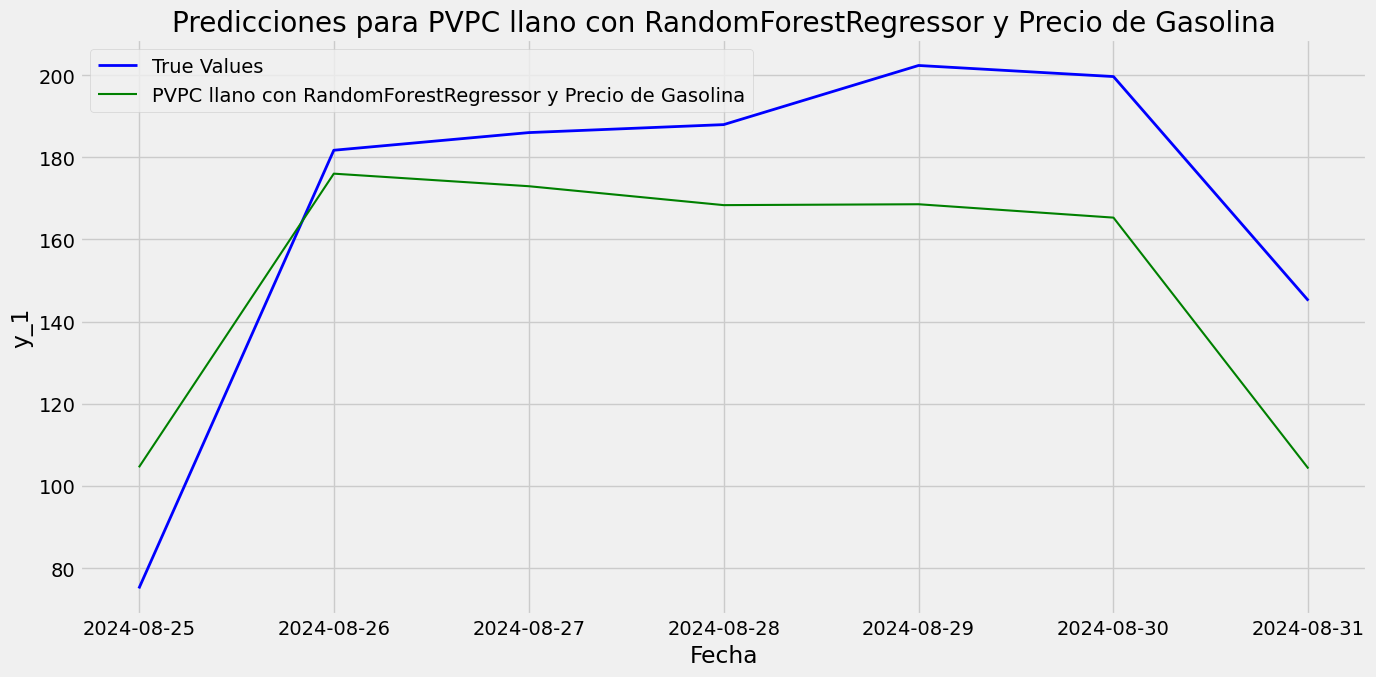

MSE para RandomForestRegressor con Demanda de Electricidad + Precio de Gasolina: 651.3702905422637


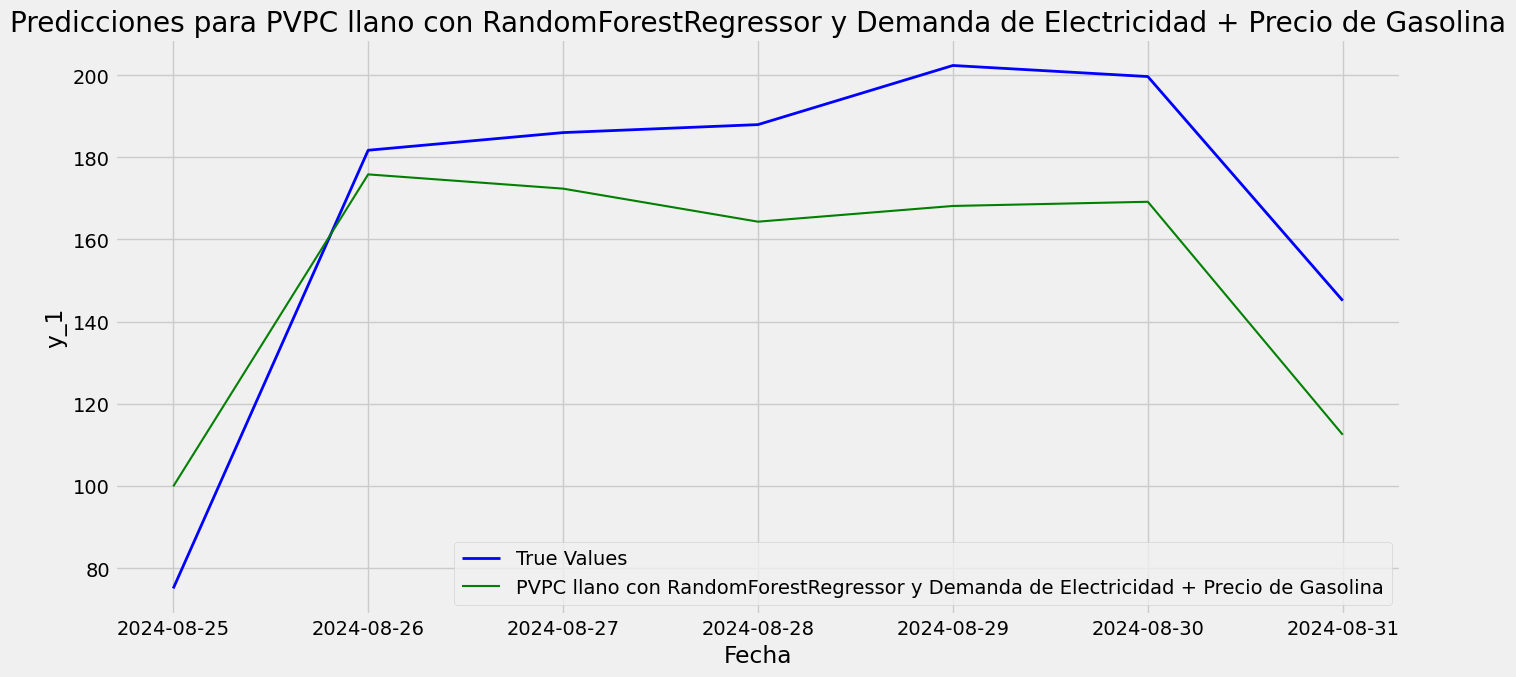

MSE para XGBRegressor con Demanda de Electricidad: 296.6093166033215


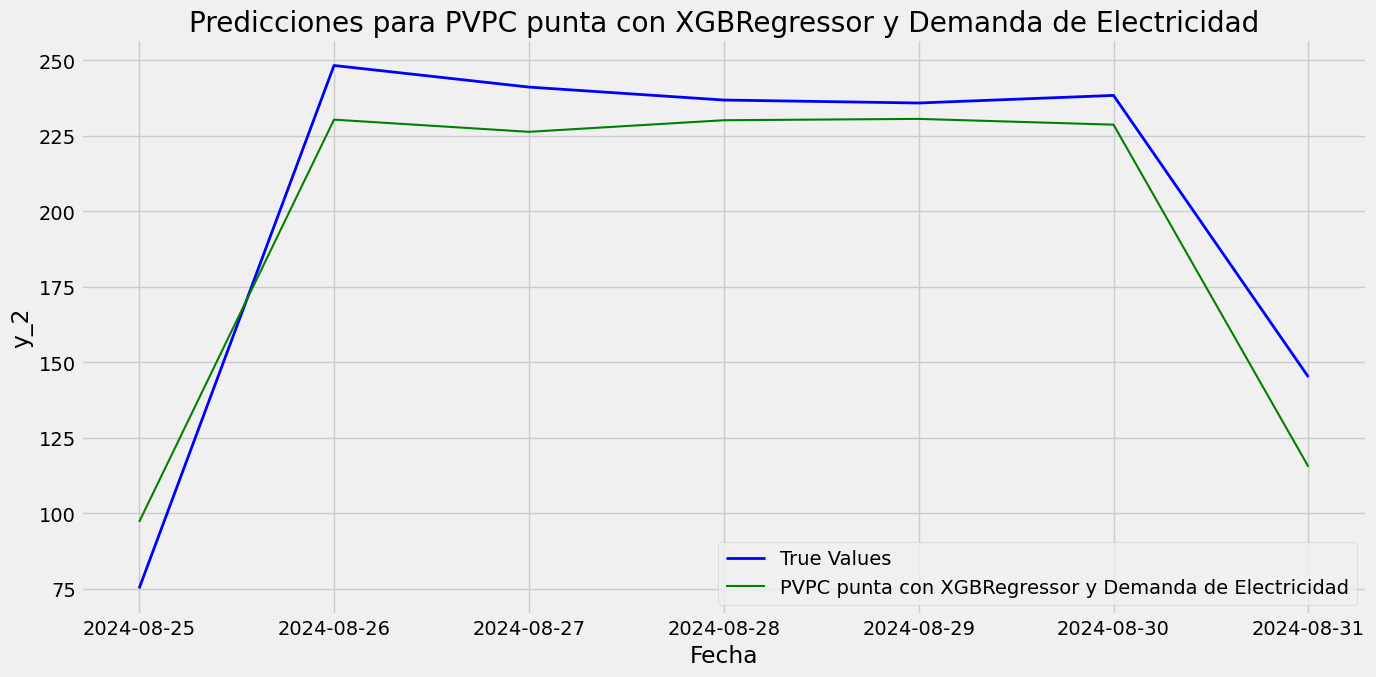

MSE para XGBRegressor con Precio de Gasolina: 596.3514013350812


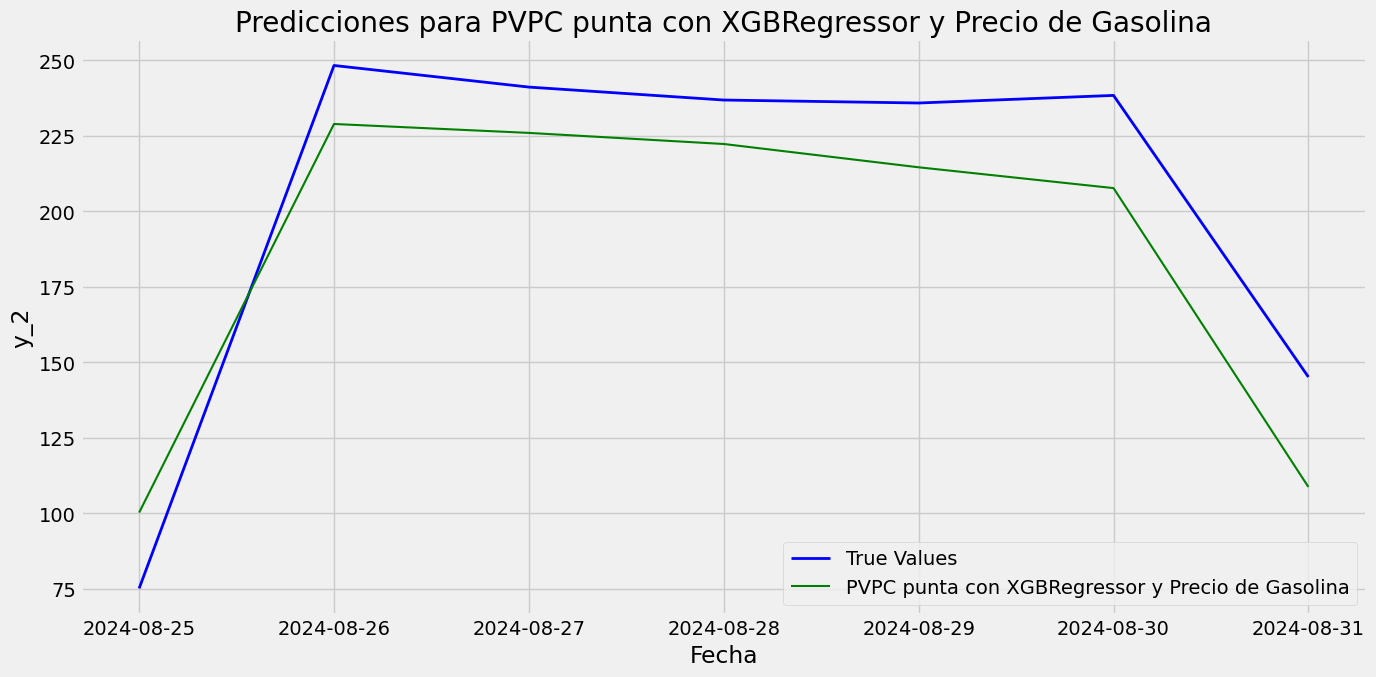

MSE para XGBRegressor con Demanda de Electricidad + Precio de Gasolina: 1003.8317143277703


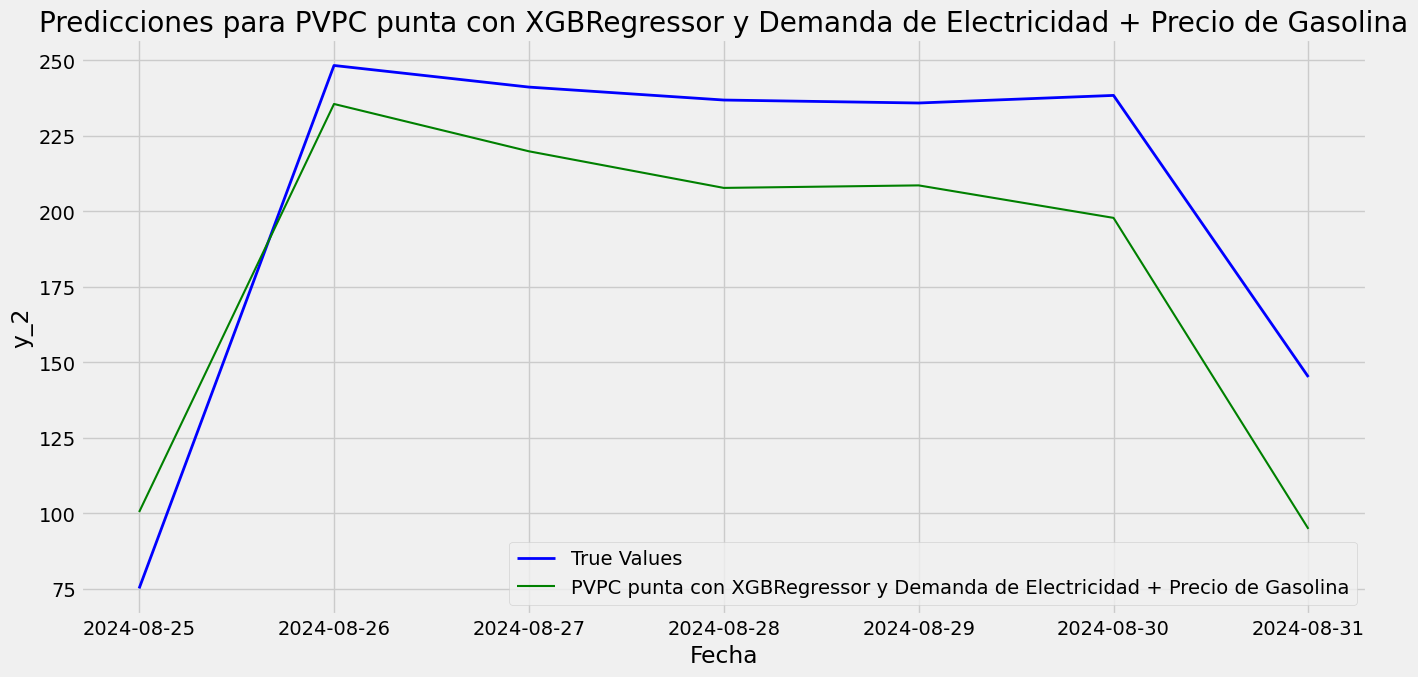

MSE para XGBRegressor con Demanda de Electricidad: 314.36926174688546


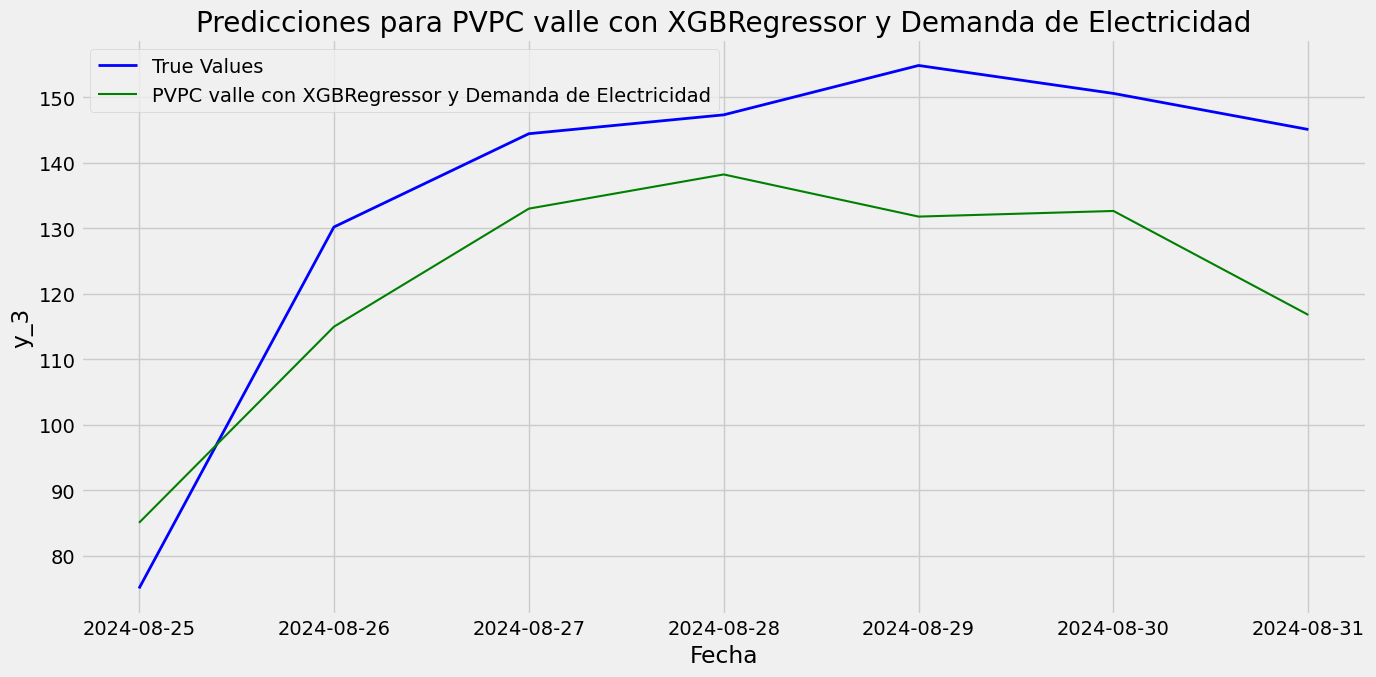

MSE para XGBRegressor con Precio de Gasolina: 650.5018654371513


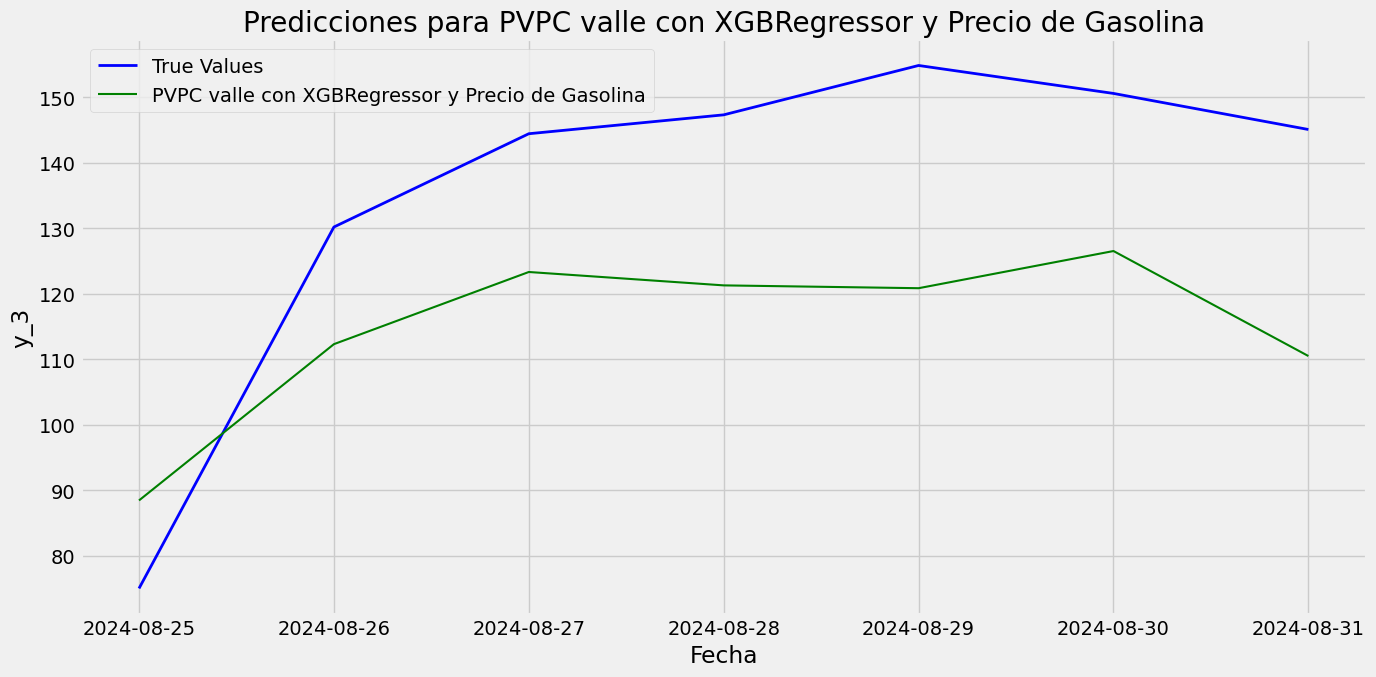

MSE para XGBRegressor con Demanda de Electricidad + Precio de Gasolina: 510.78057977775205


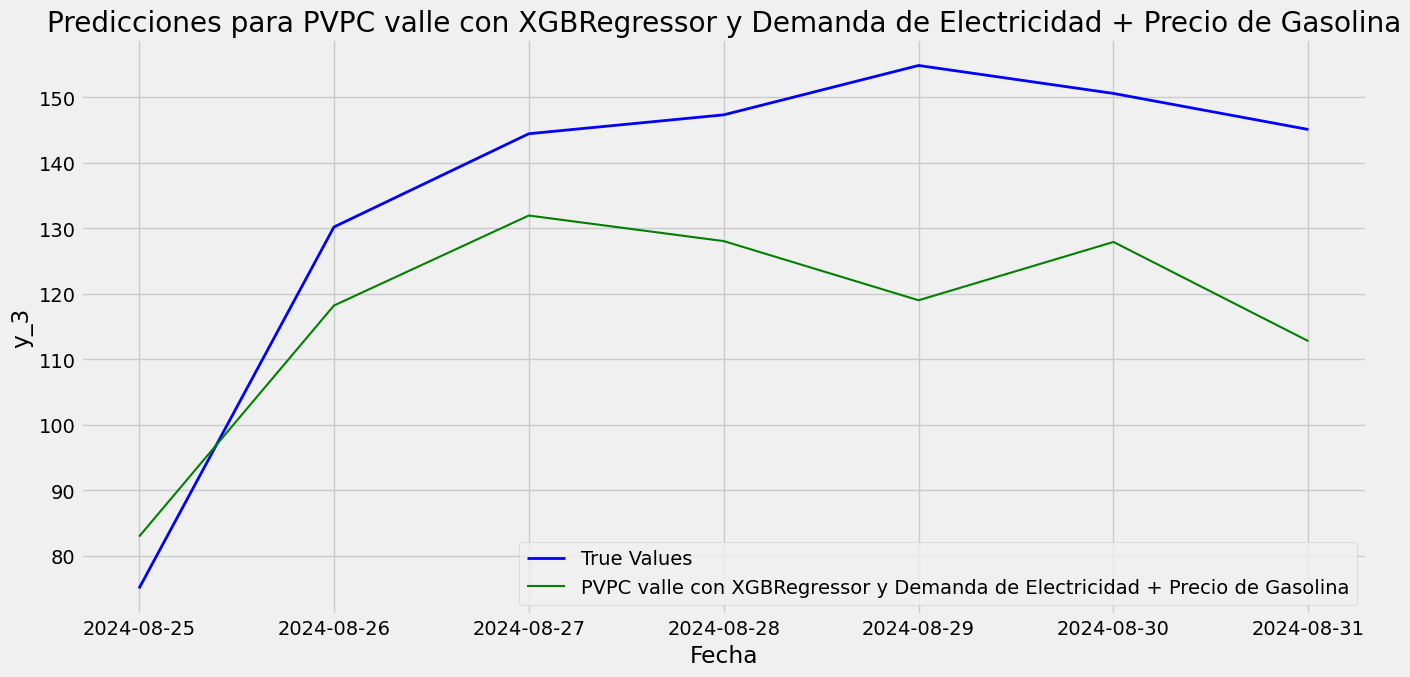

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Definimos los lags por variable objetivo
lags = {'y_1': lags_y_1, 'y_2': lags_y_2, 'y_3': lags_y_3}

# Función para ajustar el modelo y hacer predicciones
def fit_and_predict(model, params, datos_train, datos_test, target_variable, exog_train=None, exog_test=None, steps=7):
    forecaster = ForecasterAutoreg(
        regressor=model(**params),
        lags=lags[target_variable]
    )

    # Ajustar el modelo usando la variable objetivo actual
    forecaster.fit(y=datos_train[target_variable], exog=exog_train)

    # Realizar predicciones
    predicciones = forecaster.predict(steps=steps, exog=exog_test)

    return predicciones

# Función para plotear las predicciones y los valores reales
def plot_predictions(y_true, pred, title):
    plt.figure(figsize=(14, 7))

    # Plot de predicciones y valores reales
    sns.lineplot(data=y_true, label='True Values', color='blue', linewidth=2)
    sns.lineplot(data=pred, label=f'{title}', color='green')

    plt.title(f'Predicciones para {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Definir los modelos para cada variable según los resultados previos
model_y1 = best_resultados_exog['Modelo'].reset_index(drop=True)[0]
model_y2 = best_resultados_exog['Modelo'].reset_index(drop=True)[1]
model_y3 = best_resultados_exog['Modelo'].reset_index(drop=True)[2]

# Diccionario de clases de modelos
modelo_dict = {
    'RandomForestRegressor': RandomForestRegressor,
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'SVR': SVR,
    'LinearRegression': LinearRegression
}

# Obtener las clases de los modelos
clase_model_y1 = modelo_dict[model_y1]
clase_model_y2 = modelo_dict[model_y2]
clase_model_y3 = modelo_dict[model_y3]

# Obtener los mejores parámetros para cada modelo
mejores_parametros_1 = best_resultados_exog['Mejores Parámetros'].reset_index(drop=True)[0]
mejores_parametros_2 = best_resultados_exog['Mejores Parámetros'].reset_index(drop=True)[1]
mejores_parametros_3 = best_resultados_exog['Mejores Parámetros'].reset_index(drop=True)[2]

# Realizar predicciones para cada serie temporal con exógenas diferentes
pred_y1_exog_1 = fit_and_predict(clase_model_y1, mejores_parametros_1, datos_train, datos_test, 'y_1', exog_train=exog_dict_1['y_1'][:-7], exog_test=exog_dict_1['y_1'][-7:])
pred_y1_exog_2 = fit_and_predict(clase_model_y1, mejores_parametros_1, datos_train, datos_test, 'y_1', exog_train=exog_dict_2['y_1'][:-7], exog_test=exog_dict_2['y_1'][-7:])
pred_y1_exog_1_2 = fit_and_predict(clase_model_y1, mejores_parametros_1, datos_train, datos_test, 'y_1', exog_train=exog_dict_combined['y_1'][:-7], exog_test=exog_dict_combined['y_1'][-7:])

pred_y2_exog_1 = fit_and_predict(clase_model_y2, mejores_parametros_2, datos_train, datos_test, 'y_2', exog_train=exog_dict_1['y_2'][:-7], exog_test=exog_dict_1['y_2'][-7:])
pred_y2_exog_2 = fit_and_predict(clase_model_y2, mejores_parametros_2, datos_train, datos_test, 'y_2', exog_train=exog_dict_2['y_2'][:-7], exog_test=exog_dict_2['y_2'][-7:])
pred_y2_exog_1_2 = fit_and_predict(clase_model_y2, mejores_parametros_2, datos_train, datos_test, 'y_2', exog_train=exog_dict_combined['y_2'][:-7], exog_test=exog_dict_combined['y_2'][-7:])

pred_y3_exog_1 = fit_and_predict(clase_model_y3, mejores_parametros_3, datos_train, datos_test, 'y_3', exog_train=exog_dict_1['y_3'][:-7], exog_test=exog_dict_1['y_3'][-7:])
pred_y3_exog_2 = fit_and_predict(clase_model_y3, mejores_parametros_3, datos_train, datos_test, 'y_3', exog_train=exog_dict_2['y_3'][:-7], exog_test=exog_dict_2['y_3'][-7:])
pred_y3_exog_1_2 = fit_and_predict(clase_model_y3, mejores_parametros_3, datos_train, datos_test, 'y_3', exog_train=exog_dict_combined['y_3'][:-7], exog_test=exog_dict_combined['y_3'][-7:])

# Calcular y mostrar el error cuadrático medio (MSE) para cada modelo
mse_y1_exog_1 = mean_squared_error(datos_test['y_1'], pred_y1_exog_1)
mse_y1_exog_2 = mean_squared_error(datos_test['y_1'], pred_y1_exog_2)
mse_y1_exog_1_2 = mean_squared_error(datos_test['y_1'], pred_y1_exog_1_2)

mse_y2_exog_1 = mean_squared_error(datos_test['y_2'], pred_y2_exog_1)
mse_y2_exog_2 = mean_squared_error(datos_test['y_2'], pred_y2_exog_2)
mse_y2_exog_1_2 = mean_squared_error(datos_test['y_2'], pred_y2_exog_1_2)

mse_y3_exog_1 = mean_squared_error(datos_test['y_3'], pred_y3_exog_1)
mse_y3_exog_2 = mean_squared_error(datos_test['y_3'], pred_y3_exog_2)
mse_y3_exog_1_2 = mean_squared_error(datos_test['y_3'], pred_y3_exog_1_2)

# Definir los nombres de las exógenas
exog_names = {
    'exog_1': 'Demanda de Electricidad',
    'exog_2': 'Precio de Gasolina',
    'exog_combined': 'Demanda de Electricidad + Precio de Gasolina'
}

# Imprimir y graficar los resultados para y_1
print(f'MSE para {model_y1} con {exog_names["exog_1"]}: {mse_y1_exog_1}')
plot_predictions(datos_test['y_1'], pred_y1_exog_1, title=f"PVPC llano con {model_y1} y {exog_names['exog_1']}")

print(f'MSE para {model_y1} con {exog_names["exog_2"]}: {mse_y1_exog_2}')
plot_predictions(datos_test['y_1'], pred_y1_exog_2, title=f"PVPC llano con {model_y1} y {exog_names['exog_2']}")

print(f'MSE para {model_y1} con {exog_names["exog_combined"]}: {mse_y1_exog_1_2}')
plot_predictions(datos_test['y_1'], pred_y1_exog_1_2, title=f"PVPC llano con {model_y1} y {exog_names['exog_combined']}")

# Repetir para y_2 y y_3
print(f'MSE para {model_y2} con {exog_names["exog_1"]}: {mse_y2_exog_1}')
plot_predictions(datos_test['y_2'], pred_y2_exog_1, title=f"PVPC punta con {model_y2} y {exog_names['exog_1']}")

print(f'MSE para {model_y2} con {exog_names["exog_2"]}: {mse_y2_exog_2}')
plot_predictions(datos_test['y_2'], pred_y2_exog_2, title=f"PVPC punta con {model_y2} y {exog_names['exog_2']}")

print(f'MSE para {model_y2} con {exog_names["exog_combined"]}: {mse_y2_exog_1_2}')
plot_predictions(datos_test['y_2'], pred_y2_exog_1_2, title=f"PVPC punta con {model_y2} y {exog_names['exog_combined']}")

print(f'MSE para {model_y3} con {exog_names["exog_1"]}: {mse_y3_exog_1}')
plot_predictions(datos_test['y_3'], pred_y3_exog_1, title=f"PVPC valle con {model_y3} y {exog_names['exog_1']}")

print(f'MSE para {model_y3} con {exog_names["exog_2"]}: {mse_y3_exog_2}')
plot_predictions(datos_test['y_3'], pred_y3_exog_2, title=f"PVPC valle con {model_y3} y {exog_names['exog_2']}")

print(f'MSE para {model_y3} con {exog_names["exog_combined"]}: {mse_y3_exog_1_2}')
plot_predictions(datos_test['y_3'], pred_y3_exog_1_2, title=f"PVPC valle con {model_y3} y {exog_names['exog_combined']}")

#### Resultados test

In [14]:
import pandas as pd

# Definir los nombres de las exógenas
exog_names = {
    'exog_1': 'Demanda de Electricidad',
    'exog_2': 'Precio de Gasolina',
    'exog_combined': 'Demanda de Electricidad + Precio de Gasolina'
}

# Crear una lista para almacenar los resultados
resultados_list = []

# Añadir los resultados de y_1
resultados_list.append({
    'Variable': 'y_1',
    'Modelo': model_y1,
    'Exogena': exog_names['exog_1'],
    'MSE': mse_y1_exog_1
})
resultados_list.append({
    'Variable': 'y_1',
    'Modelo': model_y1,
    'Exogena': exog_names['exog_2'],
    'MSE': mse_y1_exog_2
})
resultados_list.append({
    'Variable': 'y_1',
    'Modelo': model_y1,
    'Exogena': exog_names['exog_combined'],
    'MSE': mse_y1_exog_1_2
})

# Añadir los resultados de y_2
resultados_list.append({
    'Variable': 'y_2',
    'Modelo': model_y2,
    'Exogena': exog_names['exog_1'],
    'MSE': mse_y2_exog_1
})
resultados_list.append({
    'Variable': 'y_2',
    'Modelo': model_y2,
    'Exogena': exog_names['exog_2'],
    'MSE': mse_y2_exog_2
})
resultados_list.append({
    'Variable': 'y_2',
    'Modelo': model_y2,
    'Exogena': exog_names['exog_combined'],
    'MSE': mse_y2_exog_1_2
})

# Añadir los resultados de y_3
resultados_list.append({
    'Variable': 'y_3',
    'Modelo': model_y3,
    'Exogena': exog_names['exog_1'],
    'MSE': mse_y3_exog_1
})
resultados_list.append({
    'Variable': 'y_3',
    'Modelo': model_y3,
    'Exogena': exog_names['exog_2'],
    'MSE': mse_y3_exog_2
})
resultados_list.append({
    'Variable': 'y_3',
    'Modelo': model_y3,
    'Exogena': exog_names['exog_combined'],
    'MSE': mse_y3_exog_1_2
})

# Convertir la lista de resultados a un DataFrame
resultados_df = pd.DataFrame(resultados_list)

# Imprimir el DataFrame
print(resultados_df)

  Variable                 Modelo  \
0      y_1  RandomForestRegressor   
1      y_1  RandomForestRegressor   
2      y_1  RandomForestRegressor   
3      y_2           XGBRegressor   
4      y_2           XGBRegressor   
5      y_2           XGBRegressor   
6      y_3           XGBRegressor   
7      y_3           XGBRegressor   
8      y_3           XGBRegressor   

                                        Exogena          MSE  
0                       Demanda de Electricidad   655.726754  
1                            Precio de Gasolina   778.029420  
2  Demanda de Electricidad + Precio de Gasolina   651.370291  
3                       Demanda de Electricidad   296.609317  
4                            Precio de Gasolina   596.351401  
5  Demanda de Electricidad + Precio de Gasolina  1003.831714  
6                       Demanda de Electricidad   314.369262  
7                            Precio de Gasolina   650.501865  
8  Demanda de Electricidad + Precio de Gasolina   510.780580  

In [15]:
print(resultados_df['MSE'])

0     655.726754
1     778.029420
2     651.370291
3     296.609317
4     596.351401
5    1003.831714
6     314.369262
7     650.501865
8     510.780580
Name: MSE, dtype: float64


#### Otras graficas

In [16]:
exog = datos[['Demanda_Llano', 'Pai Gasolina 95 E5']]
# Usar la columna 'Demanda_Llano' como variable exógena
datos['exog_1_1'] = datos['Demanda_Llano']
datos['exog_1_2'] = datos['Demanda_Punta']
datos['exog_1_3'] = datos['Demanda_Valle']

# Usar la columna 'Pai Gasolina 95 E5' como variable exógena
datos['exog_2'] = datos['Pai Gasolina 95 E5']

# Usar ambas columnas como variables exógenas
exog = datos[['Demanda_Llano', 'Pai Gasolina 95 E5']]

In [18]:
"""
fig, ax = plt.subplots(figsize=(9, 4))
for i in range(1,4):
  datos[f'y_{i}'].plot(ax=ax, label=f'y_{i}')
for j in range(1, 5):
    datos[f'exog_{j}'].plot(ax=ax, label=f'exog_{j}')
ax.legend();
"""

"\nfig, ax = plt.subplots(figsize=(9, 4))\nfor i in range(1,4):\n  datos[f'y_{i}'].plot(ax=ax, label=f'y_{i}')\nfor j in range(1, 5):\n    datos[f'exog_{j}'].plot(ax=ax, label=f'exog_{j}')\nax.legend();\n"

In [20]:
# Separación datos train-test
# ==============================================================================
steps = 7
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
exog_train = exog[:-steps]
exog_test  = exog[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

params_y1 = RandomForestRegressor(random_state=123).get_params()
params_y2 = XGBRegressor(random_state=123).get_params()
params_y3 = XGBRegressor(random_state=123).get_params()

lags_y_1 = pd.read_csv('data/lags_significativos_tramo_llano.csv')['Lag'].values
lags_y_2 = pd.read_csv('data/lags_significativos_tramo_punta.csv')['Lag'].values
lags_y_3 = pd.read_csv('data/lags_significativos_tramo_valle.csv')['Lag'].values

Fechas train : 2022-10-01 00:00:00 --- 2024-08-24 00:00:00  (n=694)
Fechas test  : 2024-08-25 00:00:00 --- 2024-08-31 00:00:00  (n=7)


In [22]:
# y_1
# Crear y entrenar forecaster para y_1 con DecisionTreeRegressor y exog_1
forecaster_y1_exog1 = ForecasterAutoreg(
                regressor = RandomForestRegressor(**params_y1),
                lags      = lags_y_1
             )
forecaster_y1_exog1.fit(y=datos_train['y_1'], exog=datos_train[['exog_1_1']])

# Crear y entrenar forecaster para y_1 con DecisionTreeRegressor y exog_2
forecaster_y1_exog2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(**params_y1),
                lags      = lags_y_1
             )
forecaster_y1_exog2.fit(y=datos_train['y_1'], exog=datos_train[['exog_2']])

# Crear y entrenar forecaster para y_1 con DecisionTreeRegressor y exog_1 y exog_2
forecaster_y1_exog12 = ForecasterAutoreg(
                regressor = RandomForestRegressor(**params_y1),
                lags      = lags_y_1
             )
forecaster_y1_exog12.fit(y=datos_train['y_1'], exog=datos_train[['exog_1_1', 'exog_2']])

In [23]:
# y_2
# Crear y entrenar forecaster para y_2 con XGBRegressor y exog_1
forecaster_y2_exog1 = ForecasterAutoreg(
                regressor = XGBRegressor(**params_y2),
                lags      = lags_y_2
             )
forecaster_y2_exog1.fit(y=datos_train['y_2'], exog=datos_train[['exog_1_2']])

# Crear y entrenar forecaster para y_2 con XGBRegressor y exog_2
forecaster_y2_exog2 = ForecasterAutoreg(
                regressor = XGBRegressor(**params_y2),
                lags      = lags_y_2
             )
forecaster_y2_exog2.fit(y=datos_train['y_2'], exog=datos_train[['exog_2']])

# Crear y entrenar forecaster para y_2 con XGBRegressor y exog_1 y exog_2
forecaster_y2_exog12 = ForecasterAutoreg(
                regressor = XGBRegressor(**params_y2),
                lags      = lags_y_2
             )
forecaster_y2_exog12.fit(y=datos_train['y_2'], exog=datos_train[['exog_1_2', 'exog_2']])

In [24]:
# y_3
# Crear y entrenar forecaster para y_3 con DecisionTreeRegressor y exog_1
forecaster_y3_exog1 = ForecasterAutoreg(
                regressor = XGBRegressor(**params_y3),
                lags      = lags_y_3
             )
forecaster_y3_exog1.fit(y=datos_train['y_3'], exog=datos_train[['exog_1_3']])

# Crear y entrenar forecaster para y_3 con DecisionTreeRegressor y exog_2
forecaster_y3_exog2 = ForecasterAutoreg(
                regressor = XGBRegressor(**params_y3),
                lags      = lags_y_3
             )
forecaster_y3_exog2.fit(y=datos_train['y_3'], exog=datos_train[['exog_2']])

# Crear y entrenar forecaster para y_3 con DecisionTreeRegressor y exog_1 y exog_2
forecaster_y3_exog12 = ForecasterAutoreg(
                regressor = XGBRegressor(**params_y3),
                lags      = lags_y_3
             )
forecaster_y3_exog12.fit(y=datos_train['y_3'], exog=datos_train[['exog_1_3', 'exog_2']])

In [25]:
# Predicciones para y_1
predicciones_y1_exog1 = forecaster_y1_exog1.predict(steps=steps, exog=datos_test[['exog_1_1']])
predicciones_y1_exog2 = forecaster_y1_exog2.predict(steps=steps, exog=datos_test[['exog_2']])
predicciones_y1_exog12 = forecaster_y1_exog12.predict(steps=steps, exog=datos_test[['exog_1_1', 'exog_2']])

# Predicciones para y_2
predicciones_y2_exog1 = forecaster_y2_exog1.predict(steps=steps, exog=datos_test[['exog_1_2']])
predicciones_y2_exog2 = forecaster_y2_exog2.predict(steps=steps, exog=datos_test[['exog_2']])
predicciones_y2_exog12 = forecaster_y2_exog12.predict(steps=steps, exog=datos_test[['exog_1_2', 'exog_2']])

# Predicciones para y_3
predicciones_y3_exog1 = forecaster_y3_exog1.predict(steps=steps, exog=datos_test[['exog_1_3']])
predicciones_y3_exog2 = forecaster_y3_exog2.predict(steps=steps, exog=datos_test[['exog_2']])
predicciones_y3_exog12 = forecaster_y3_exog12.predict(steps=steps, exog=datos_test[['exog_1_3', 'exog_2']])

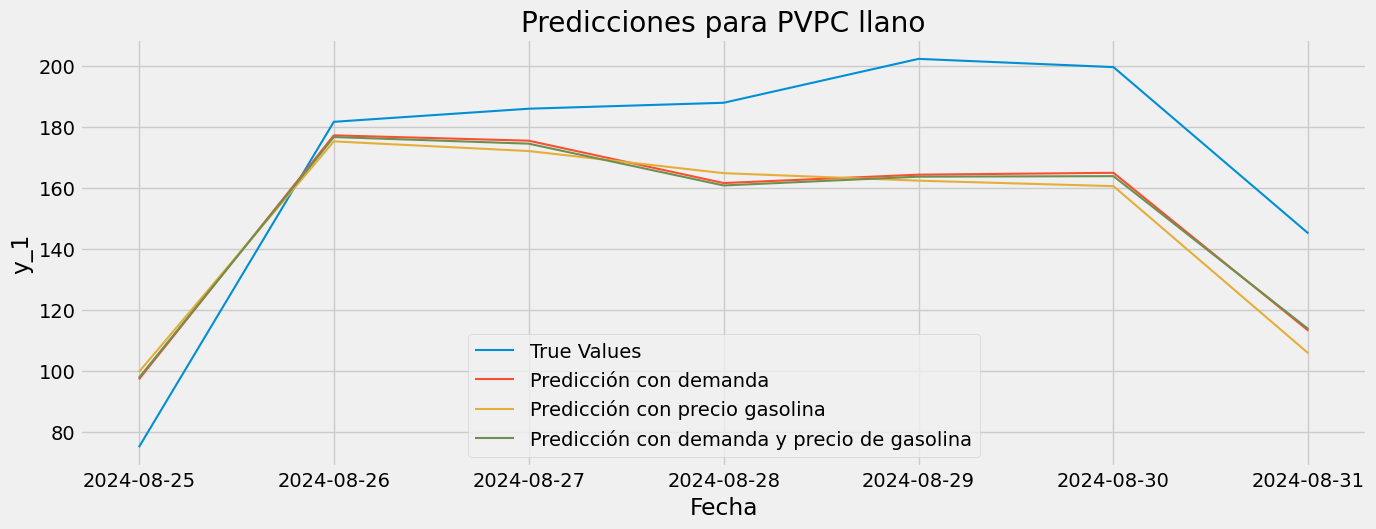

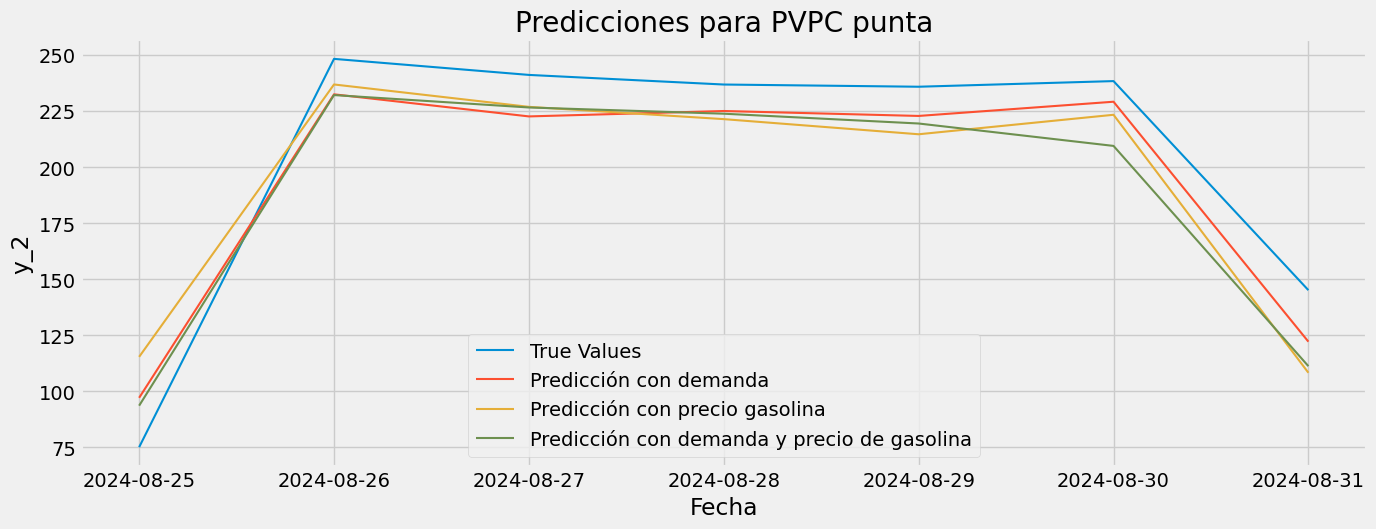

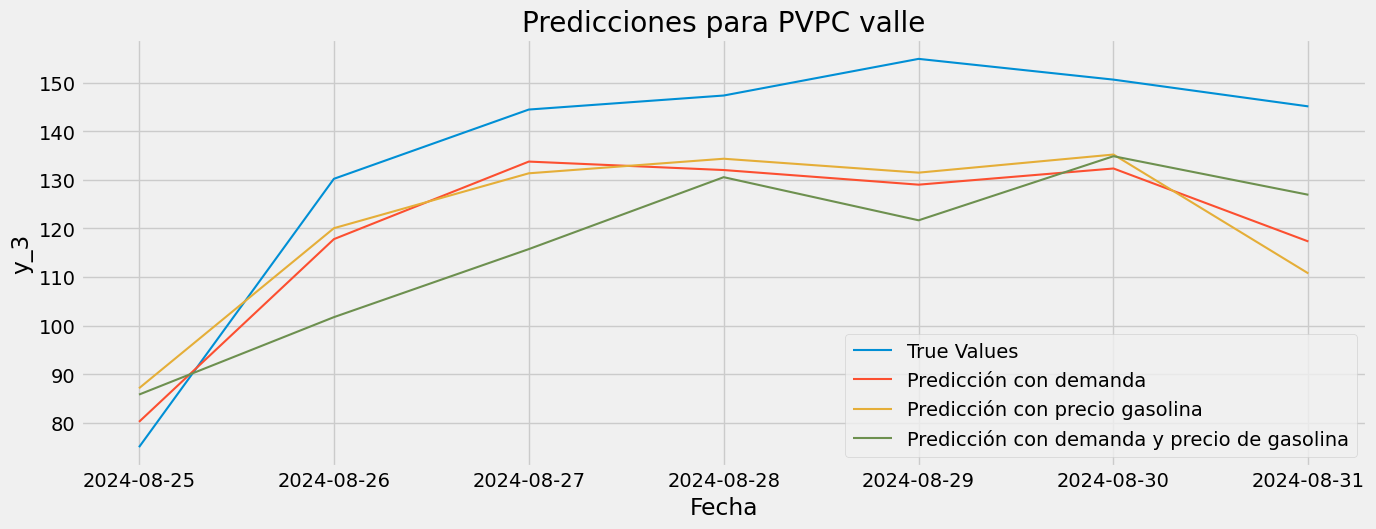

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Función para graficar predicciones y errores usando R2
def plot_predictions_and_errors(y_true, pred1, pred2, pred12, title):
    r2_1 = r2_score(y_true, pred1)
    r2_2 = r2_score(y_true, pred2)
    r2_12 = r2_score(y_true, pred12)

    plt.figure(figsize=(14, 10))

    # Plot de predicciones
    plt.subplot(2, 1, 1)
    sns.lineplot(data=y_true, label='True Values')
    sns.lineplot(data=pred1, label=f'Predicción con demanda')
    sns.lineplot(data=pred2, label=f'Predicción con precio gasolina')
    sns.lineplot(data=pred12, label=f'Predicción con demanda y precio de gasolina')
    if title == 'y_1':
        plt.title(f'Predicciones para PVPC llano')
    elif title == 'y_2':
        plt.title(f'Predicciones para PVPC punta')
    elif title == 'y_3':
        plt.title(f'Predicciones para PVPC valle')
    else:
        plt.title(f'Predicciones para {title}')
    plt.legend()

    # Plot de errores
    # plt.subplot(2, 1, 2)
    # sns.lineplot(data=y_true - pred1, label=f'Error con exog_1 (R2={r2_1:.2f})')
    # sns.lineplot(data=y_true - pred2, label=f'Error con exog_2 (R2={r2_2:.2f})')
    # sns.lineplot(data=y_true - pred12, label=f'Error con exog_1 y exog_2 (R2={r2_12:.2f})')
    # plt.title(f'Errores para {title}')
    # plt.legend()

    plt.tight_layout()
    plt.show()

# Datos verdaderos
y_true_y1 = datos_test['y_1']
y_true_y2 = datos_test['y_2']
y_true_y3 = datos_test['y_3']


# Graficar para y_1
plot_predictions_and_errors(y_true_y1, predicciones_y1_exog1, predicciones_y1_exog2, predicciones_y1_exog12, 'y_1')

# Graficar para y_2
plot_predictions_and_errors(y_true_y2, predicciones_y2_exog1, predicciones_y2_exog2, predicciones_y2_exog12, 'y_2')

# Graficar para y_3
plot_predictions_and_errors(y_true_y3, predicciones_y3_exog1, predicciones_y3_exog2, predicciones_y3_exog12, 'y_3')

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Supongamos que tienes los valores reales y las predicciones en las siguientes variables
valores_reales_y1 = datos_test['y_1']
valores_reales_y2 = datos_test['y_2']
valores_reales_y3 = datos_test['y_3']

# Variables exógenas y sus etiquetas
vars_exog = ['demanda', 'precio gasoleo', 'demanda y precio gasoleo']
num_exog = [1, 2, 12]

# Lista para almacenar resultados
resultados_exog = []

# Bucle para calcular las métricas para cada variable
for i in range(1, 4):
    for j in range(len(vars_exog)):
        # Acceder dinámicamente a los valores reales y predicciones
        valores_reales = eval(f'valores_reales_y{i}')
        predicciones = eval(f'predicciones_y{i}_exog{num_exog[j]}')

        # Calcular métricas de bondad
        mse = mean_squared_error(valores_reales, predicciones)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(valores_reales, predicciones)
        mape = np.mean(np.abs((valores_reales - predicciones) / valores_reales)) * 100
        r2 = r2_score(valores_reales, predicciones)

        # Almacenar resultados en la lista
        resultados_exog.append({
            'Variables exógenas': vars_exog[j],
            'Variable': f'y_{i}',
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        })

# Convertir los resultados a un DataFrame
resultados_exog = pd.DataFrame(resultados_exog)
resultados_exog

Variables exógenas Variable          MSE       RMSE        MAE  \
0                   demanda      y_1   459.411404  21.433884  18.041306   
1            precio gasoleo      y_1  2505.883068  50.058796  42.297745   
2  demanda y precio gasoleo      y_1   483.447699  21.987444  17.139749   
3                   demanda      y_2   285.828840  16.906473  16.200796   
4            precio gasoleo      y_2   649.189661  25.479201  22.850458   
5  demanda y precio gasoleo      y_2   605.125969  24.599308  21.631584   
6                   demanda      y_3    46.596351   6.826152   6.190334   
7            precio gasoleo      y_3    38.835660   6.231826   5.450335   
8  demanda y precio gasoleo      y_3    67.834892   8.236194   7.073812   

        MAPE        R2  
0  13.509101  0.737561  
1  28.122223 -0.431485  
2  12.175967  0.723831  
3  10.517391  0.925108  
4  15.300432  0.829901  
5  13.960690  0.841447  
6   4.786931  0.929068  
7   4.267293  0.940882  
8   6.195262  0.896737

In [ ]:
resultados_exog['Variable'] = resultados_exog['Variable'].apply(replace_etiqueta_por_valor_real)
resultados_exog.groupby('Variable').apply(lambda x: x.sort_values(by='R2', ascending=False)).reset_index(drop=True)

<ipython-input-72-e21dd485fb49>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resultados_exog.groupby('Variable').apply(lambda x: x.sort_values(by='R2', ascending=False)).reset_index(drop=True)


Variables exógenas Variable          MSE       RMSE        MAE  \
0                   demanda    Llano   459.411404  21.433884  18.041306   
1  demanda y precio gasoleo    Llano   483.447699  21.987444  17.139749   
2            precio gasoleo    Llano  2505.883068  50.058796  42.297745   
3                   demanda    Punta   285.828840  16.906473  16.200796   
4  demanda y precio gasoleo    Punta   605.125969  24.599308  21.631584   
5            precio gasoleo    Punta   649.189661  25.479201  22.850458   
6            precio gasoleo    Valle    38.835660   6.231826   5.450335   
7                   demanda    Valle    46.596351   6.826152   6.190334   
8  demanda y precio gasoleo    Valle    67.834892   8.236194   7.073812   

        MAPE        R2  
0  13.509101  0.737561  
1  12.175967  0.723831  
2  28.122223 -0.431485  
3  10.517391  0.925108  
4  13.960690  0.841447  
5  15.300432  0.829901  
6   4.267293  0.940882  
7   4.786931  0.929068  
8   6.195262  0.896737